In [ ]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

# NLP libraries
import spacy
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

# ML helpers (reuse your existing ones)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load original dataset
df_raw = pd.read_csv('/content/drive/MyDrive/NLP_FINAL/dataset/games_reviews_info.csv')
df_raw.head()

,Unnamed: 0,game,avg_user_score,meta_score,user_score,review
0,0,/game/kingdom-come-deliverance-ii-mysteria-ecc...,7.4,81,10.0,Hasta el momento muy contento con Misteria Ecc...
1,1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ..."
2,2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.]
3,3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...
4,4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"I normally do not enjoy these kind of games, b..."


## Fuzz game name in review

In [ ]:
# Fuzz game name in review
import re

def normalize_simple(text):
    text = str(text)  # <-- FIX: Convert NaN/float to string
    text = text.replace(':', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def extract_game_name(game_path):
    name = str(game_path).replace('/game/', '').strip('/')
    name = normalize_simple(name).lower()
    return name

def replace_game_name_in_review(row):
    review = normalize_simple(row['review'])   # SAFE: converted to string
    game_name = str(row['game_name'])          # SAFE: avoid float issues

    escaped_name = re.escape(game_name)
    pattern = re.compile(r'\b' + escaped_name + r'\b', re.IGNORECASE)

    cleaned = pattern.sub("the game", review)
    return cleaned

df_raw['game_name'] = df_raw['game'].apply(extract_game_name)
df_raw['review_fuzzed'] = df_raw.apply(replace_game_name_in_review, axis=1)

df_raw[['game', 'game_name', 'review', 'review_fuzzed']].head(10)

,game,game_name,review,review_fuzzed
0,/game/kingdom-come-deliverance-ii-mysteria-ecc...,kingdom come deliverance ii mysteria ecclesiae,Hasta el momento muy contento con Misteria Ecc...,Hasta el momento muy contento con Misteria Ecc...
1,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,"I loved this game the whole way through, even ...","I loved this game the whole way through, even ..."
2,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,[SPOILER ALERT: This review contains spoilers.],[SPOILER ALERT This review contains spoilers.]
3,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,Hyrule Warriors: Age of Imprisonment stands ou...,"the game stands out, in my opinion, as the bes..."
4,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,"I normally do not enjoy these kind of games, b...","I normally do not enjoy these kind of games, b..."
5,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,I have played Hyrule Warriors on the 3DS and n...,I have played Hyrule Warriors on the 3DS and n...
6,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,Minha crítica de Hyrule Warriors: Age of Impri...,Minha crítica de the game the game surpreende ...
7,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,"Despite the average story, this is easily the ...","Despite the average story, this is easily the ..."
8,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,Perfect game good story keeps you hooked and w...,Perfect game good story keeps you hooked and w...
9,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,The best in the series by far. Ignore the fact...,The best in the series by far. Ignore the fact...


In [ ]:
df = df_raw.copy()

In [ ]:
df['review_fuzzed']

,review_fuzzed
0,Hasta el momento muy contento con Misteria Ecc...
1,"I loved this game the whole way through, even ..."
2,[SPOILER ALERT This review contains spoilers.]
3,"the game stands out, in my opinion, as the bes..."
4,"I normally do not enjoy these kind of games, b..."
...,...
13531,Beautiful world great story on gamepass u can ...
13532,Ten out of ten. Reminds me some much the vibes...
13533,"the game é uma experiência sensacional, um jog..."
13534,Beautiful & tonnes of Double Fine charm I abso...


In [ ]:
# Check how many reviews changed after fuzzing
df_raw['changed'] = df_raw['review'] != df_raw['review_fuzzed']
df_raw['changed'].mean(), df_raw['changed'].sum()

(np.float64(0.4697842789598109), np.int64(6359))

In [ ]:
# examples that changed
df_raw[df_raw["changed"]].head()

,Unnamed: 0,game,avg_user_score,meta_score,user_score,review,game_name,review_fuzzed,changed
0,0,/game/kingdom-come-deliverance-ii-mysteria-ecc...,7.4,81,10.0,Hasta el momento muy contento con Misteria Ecc...,kingdom come deliverance ii mysteria ecclesiae,Hasta el momento muy contento con Misteria Ecc...,True
2,2,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,[SPOILER ALERT: This review contains spoilers.],hyrule warriors age of imprisonment,[SPOILER ALERT This review contains spoilers.],True
3,3,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,Hyrule Warriors: Age of Imprisonment stands ou...,hyrule warriors age of imprisonment,"the game stands out, in my opinion, as the bes...",True
4,4,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"I normally do not enjoy these kind of games, b...",hyrule warriors age of imprisonment,"I normally do not enjoy these kind of games, b...",True
5,5,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,I have played Hyrule Warriors on the 3DS and n...,hyrule warriors age of imprisonment,I have played Hyrule Warriors on the 3DS and n...,True


In [ ]:
# examples that did not change
df_raw[~df_raw["changed"]].head()

,Unnamed: 0,game,avg_user_score,meta_score,user_score,review,game_name,review_fuzzed,changed
1,1,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,9.0,"I loved this game the whole way through, even ...",hyrule warriors age of imprisonment,"I loved this game the whole way through, even ...",False
8,8,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,Perfect game good story keeps you hooked and w...,hyrule warriors age of imprisonment,Perfect game good story keeps you hooked and w...,False
9,9,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,The best in the series by far. Ignore the fact...,hyrule warriors age of imprisonment,The best in the series by far. Ignore the fact...,False
10,10,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,전작인 젤다무쌍 대재앙의 시대와 비교하면 그래픽도 좋고 60프레임에 호쾌한 액션도 ...,hyrule warriors age of imprisonment,전작인 젤다무쌍 대재앙의 시대와 비교하면 그래픽도 좋고 60프레임에 호쾌한 액션도 ...,False
11,11,/game/hyrule-warriors-age-of-imprisonment/,8.7,79,10.0,"Intense and addictive,It grows on you with eve...",hyrule warriors age of imprisonment,"Intense and addictive,It grows on you with eve...",False


In [ ]:
# How many reviews were partially replaced, not completely unchanged
df_raw["review_fuzzed"].str.contains("the game").mean()

np.float64(0.29085401891252954)

In [ ]:
df['text'] = df['review_fuzzed']

In [ ]:
# Drop unusable rows BEFORE language detection
df = df[df['text'].astype(str).str.strip() != ""]
df = df.dropna(subset=['text'])

In [ ]:
# Clean up extra columns
df = df[['game', 'game_name', 'meta_score', 'user_score', 'avg_user_score', 'text']]
df.head()

,game,game_name,meta_score,user_score,avg_user_score,text
0,/game/kingdom-come-deliverance-ii-mysteria-ecc...,kingdom come deliverance ii mysteria ecclesiae,81,10.0,7.4,Hasta el momento muy contento con Misteria Ecc...
1,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,79,9.0,8.7,"I loved this game the whole way through, even ..."
2,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,79,9.0,8.7,[SPOILER ALERT This review contains spoilers.]
3,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,79,9.0,8.7,"the game stands out, in my opinion, as the bes..."
4,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,79,10.0,8.7,"I normally do not enjoy these kind of games, b..."


In [ ]:
# Install library
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=49409fe66c68c797f0a1987a0496aa702e219c31d53d6d99cce3c8fe628b979f
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # reproducibility

In [ ]:
def detect_language(text):
    try:
        if isinstance(text, str) and len(text.strip()) > 5:
            return detect(text)
        else:
            return "unknown"
    except:
        return "error"

In [ ]:
# Apply language detection on fuzzed review text
df['lang'] = df['text'].apply(detect_language)

In [ ]:
# Check Language Distribution
df['lang'].value_counts()

,count
lang,
en,10490
es,901
pt,711
fr,460
ru,189
it,184
tr,143
de,123
zh-cn,43


In [ ]:
# % distribution
df['lang'].value_counts(normalize=True) * 100

,proportion
lang,
en,77.514224
es,6.657799
pt,5.253824
fr,3.399098
ru,1.396586
it,1.359639
tr,1.056676
de,0.908889
zh-cn,0.317742


In [ ]:
# Inspect non-English reviews
non_english_df = df[df['lang'] != 'en']
non_english_df[['text']].head(30)

,text
0,Hasta el momento muy contento con Misteria Ecc...
6,Minha crítica de the game the game surpreende ...
10,전작인 젤다무쌍 대재앙의 시대와 비교하면 그래픽도 좋고 60프레임에 호쾌한 액션도 ...
20,Hyrule Warriors é a fusão perfeita entre Zelda...
33,Un Banger qui scelle enfin le destin d’HyruleA...
34,Performance le jeu est fluide et tient les 60 ...
36,the game redonne vie au classique culte de Ben...
40,"Jogo chegou incrível, levando um prazer de jog..."
56,新的UI导致了巨大的问题，老玩家开始不知所措，而且有严重的各种bug，再补充一点，不知道费劲...
89,Nach 49 Stunden und dem fehlen eines richtigen...


In [ ]:
# Keep English only
df_en = df[df['lang'] == 'en'].copy()
df_en.shape

(10490, 7)

# Preprocessing Cleaning Tokens (Lowercase, URLs, HTML, punctuation, digits, stopwords, short words)

In [ ]:
# 1. Contraction Expansion
!pip install contractions
import contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.3 MB/s eta 0:00:00


In [ ]:
def contraction_expansion(text):
    expanded = []
    for word in text.split():
        expanded.append(contractions.fix(word))
    return ' '.join(expanded)

In [ ]:
# IMPORTANT: use fuzzed review ("text"), NOT the original raw review
df_en['review_expanded'] = df_en['text'].apply(contraction_expansion)

In [ ]:
# 2. Tokenization (spaCy)
import spacy
nlp = spacy.load("en_core_web_sm")

df_en['review_tokens'] = df_en['review_expanded'].apply(
    lambda x: [token.text for token in nlp(x)]
)

In [ ]:
# 3. Cleaning tokens
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def clean_tokens(tokens):
    cleaned = []
    for token in tokens:
        token = token.lower()
        token = re.sub(r"http\S+|www\S+|https\S+", "", token)
        token = re.sub(r"<.*?>", "", token)
        token = re.sub(r"[^a-zA-Z]", "", token)
        if len(token) < 3: continue
        if any(char.isdigit() for char in token): continue
        if token in stop_words: continue
        cleaned.append(token)
    return cleaned

df_en["clean_tokens"] = df_en["review_tokens"].apply(clean_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 4. POS Tagging
def spacy_pos(tokens):
    doc = nlp(" ".join(tokens))
    return [(token.text, token.pos_) for token in doc]

df_en['pos_tags'] = df_en['clean_tokens'].apply(spacy_pos)

In [ ]:
df_en[["review_tokens", "clean_tokens"]].head(3)

,review_tokens,clean_tokens
1,"[I, loved, this, game, the, whole, way, throug...","[loved, game, whole, way, even, someone, despi..."
2,"[[, SPOILER, ALERT, This, review, contains, sp...","[spoiler, alert, review, contains, spoilers]"
3,"[the, game, stands, out, ,, in, my, opinion, ,...","[game, stands, opinion, best, entry, hyrule, w..."


In [ ]:
# Output check: see tokens and POS tags for first 2 rows
df_en[['clean_tokens', 'pos_tags']].head(3)

,clean_tokens,pos_tags
1,"[loved, game, whole, way, even, someone, despi...","[(loved, VERB), (game, NOUN), (whole, ADJ), (w..."
2,"[spoiler, alert, review, contains, spoilers]","[(spoiler, PROPN), (alert, NOUN), (review, NOU..."
3,"[game, stands, opinion, best, entry, hyrule, w...","[(game, NOUN), (stands, VERB), (opinion, NOUN)..."


In [ ]:
# 5. Lemmatization
def lemmatize_spacy(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = []
    for token in doc:
        if token.is_punct or token.is_space: continue
        if token.is_stop: continue
        lemmas.append(token.lemma_)
    return lemmas

%time df_en['lemmas'] = df_en['clean_tokens'].apply(lemmatize_spacy)

# Output check: see clean_tokens vs lemmas
df_en[['clean_tokens', 'lemmas']].head(3)

CPU times: user 1min 25s, sys: 124 ms, total: 1min 26s
Wall time: 1min 27s


,clean_tokens,lemmas
1,"[loved, game, whole, way, even, someone, despi...","[love, game, way, despise, age, calamity, game..."
2,"[spoiler, alert, review, contains, spoilers]","[spoiler, alert, review, contain, spoiler]"
3,"[game, stands, opinion, best, entry, hyrule, w...","[game, stand, opinion, good, entry, hyrule, wa..."


In [ ]:
df_en.head()

,game,game_name,meta_score,user_score,avg_user_score,text,lang,review_expanded,review_tokens,clean_tokens,pos_tags,lemmas
1,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,79,9.0,8.7,"I loved this game the whole way through, even ...",en,"I loved this game the whole way through, even ...","[I, loved, this, game, the, whole, way, throug...","[loved, game, whole, way, even, someone, despi...","[(loved, VERB), (game, NOUN), (whole, ADJ), (w...","[love, game, way, despise, age, calamity, game..."
2,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,79,9.0,8.7,[SPOILER ALERT This review contains spoilers.],en,[SPOILER ALERT This review contains spoilers.],"[[, SPOILER, ALERT, This, review, contains, sp...","[spoiler, alert, review, contains, spoilers]","[(spoiler, PROPN), (alert, NOUN), (review, NOU...","[spoiler, alert, review, contain, spoiler]"
3,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,79,9.0,8.7,"the game stands out, in my opinion, as the bes...",en,"the game stands out, in my opinion, as the bes...","[the, game, stands, out, ,, in, my, opinion, ,...","[game, stands, opinion, best, entry, hyrule, w...","[(game, NOUN), (stands, VERB), (opinion, NOUN)...","[game, stand, opinion, good, entry, hyrule, wa..."
4,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,79,10.0,8.7,"I normally do not enjoy these kind of games, b...",en,"I normally do not enjoy these kind of games, b...","[I, normally, do, not, enjoy, these, kind, of,...","[normally, enjoy, kind, games, one, really, su...","[(normally, ADV), (enjoy, VERB), (kind, ADJ), ...","[normally, enjoy, kind, game, surprise, work, ..."
5,/game/hyrule-warriors-age-of-imprisonment/,hyrule warriors age of imprisonment,79,10.0,8.7,I have played Hyrule Warriors on the 3DS and n...,en,I have played Hyrule Warriors on the 3DS and n...,"[I, have, played, Hyrule, Warriors, on, the, 3...","[played, hyrule, warriors, never, made, far, l...","[(played, VERB), (hyrule, NOUN), (warriors, NO...","[play, hyrule, warrior, far, like, zelda, huge..."


In [ ]:
# 6. Final clean_text
df_en['clean_text'] = df_en['lemmas'].apply(lambda x: " ".join(x))

In [ ]:
# 7. Summary statistics
df_en['len_tokens'] = df_en['review_tokens'].apply(len)
df_en['len_clean_tokens'] = df_en['clean_tokens'].apply(len)

print("Avg tokens BEFORE cleaning:", df_en['len_tokens'].mean())
print("Avg tokens AFTER cleaning:", df_en['len_clean_tokens'].mean())

df_en[['text', 'clean_text']].head()

Avg tokens BEFORE cleaning: 91.09742612011439
Avg tokens AFTER cleaning: 40.435653002859866


,text,clean_text
1,"I loved this game the whole way through, even ...",love game way despise age calamity game phenom...
2,[SPOILER ALERT This review contains spoilers.],spoiler alert review contain spoiler
3,"the game stands out, in my opinion, as the bes...",game stand opinion good entry hyrule warrior s...
4,"I normally do not enjoy these kind of games, b...",normally enjoy kind game surprise work perfect...
5,I have played Hyrule Warriors on the 3DS and n...,play hyrule warrior far like zelda huge zelda ...


## Statistics & Lexical Diversity

In [ ]:
# 1. Lexical Diversity Function
def calculate_lexical_diversity(tokens):
    if not tokens:
        return 0
    return len(set(tokens)) / len(tokens)

df_en['lexical_diversity'] = df_en['lemmas'].apply(calculate_lexical_diversity)

avg_lexical_diversity = df_en['lexical_diversity'].mean()
print(f"Average Lexical Diversity: {avg_lexical_diversity:.4f}")

Average Lexical Diversity: 0.8892


In [ ]:
# 2. Total Unique Tokens in Entire Corpus
all_tokens = []
for tokens_list in df_en['lemmas']:
    all_tokens.extend(tokens_list)

total_unique_tokens = len(set(all_tokens))
print(f"Total Unique Tokens: {total_unique_tokens}")

Total Unique Tokens: 14832


In [ ]:
# 3. Average Processed Token Count
df_en['processed_token_count'] = df_en['lemmas'].apply(len)
avg_processed_token_count = df_en['processed_token_count'].mean()

print(f"Average Processed Token Count: {avg_processed_token_count:.2f}")

Average Processed Token Count: 35.09


# Task 3: Data Understanding and Preparation

In [ ]:
# Data Understanding
# user_score and meta_score
# Import the required libraries

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
# DATA UNDERSTANDING & PREPARATION

# Quick sanity check
print(df_en[['user_score', 'meta_score']].describe())

        user_score    meta_score
count  1544.000000  10490.000000
mean      7.446891     89.817827
std       3.203777      5.719046
min       0.000000     70.000000
25%       6.000000     86.000000
50%       9.000000     92.000000
75%      10.000000     94.000000
max      10.000000     96.000000


## User Score — Distribution, Missingness, Normalization

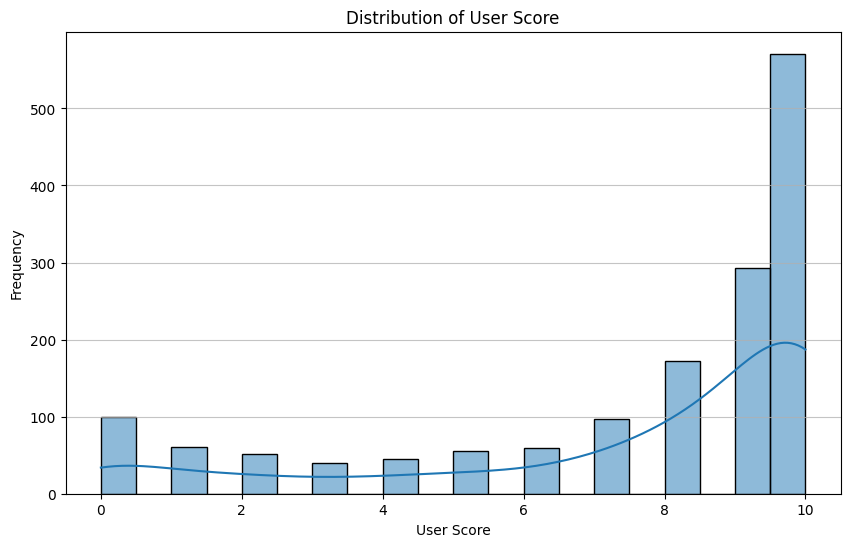

In [ ]:
# ---- USER SCORE DISTRIBUTION ----
plt.figure(figsize=(10, 6))
sns.histplot(df_en['user_score'], bins=20, kde=True)
plt.title('Distribution of User Score')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# MISSING VALUES
empty_user_score_rows_count = df_en['user_score'].isnull().sum()
print(f"Number of rows with empty user_score: {empty_user_score_rows_count}")

Number of rows with empty user_score: 8946


In [ ]:
# NORMALIZATION
# Normalize user_score from 0–10 to -1 to +1
df_en['normalized_user_score'] = df_en['user_score'].apply(
    lambda x: (x / 5) - 1 if pd.notna(x) else x
)

In [ ]:
print("Original User Score Description:")
print(df_en['user_score'].describe())

print("\nNormalized User Score Description:")
print(df_en['normalized_user_score'].describe())

print("\nFirst 5 rows with original and normalized user scores:")
print(df_en[['user_score', 'normalized_user_score']].head())

Original User Score Description:
count    1544.000000
mean        7.446891
std         3.203777
min         0.000000
25%         6.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: user_score, dtype: float64

Normalized User Score Description:
count    1544.000000
mean        0.489378
std         0.640755
min        -1.000000
25%         0.200000
50%         0.800000
75%         1.000000
max         1.000000
Name: normalized_user_score, dtype: float64

First 5 rows with original and normalized user scores:
   user_score  normalized_user_score
1         9.0                    0.8
2         9.0                    0.8
3         9.0                    0.8
4        10.0                    1.0
5        10.0                    1.0


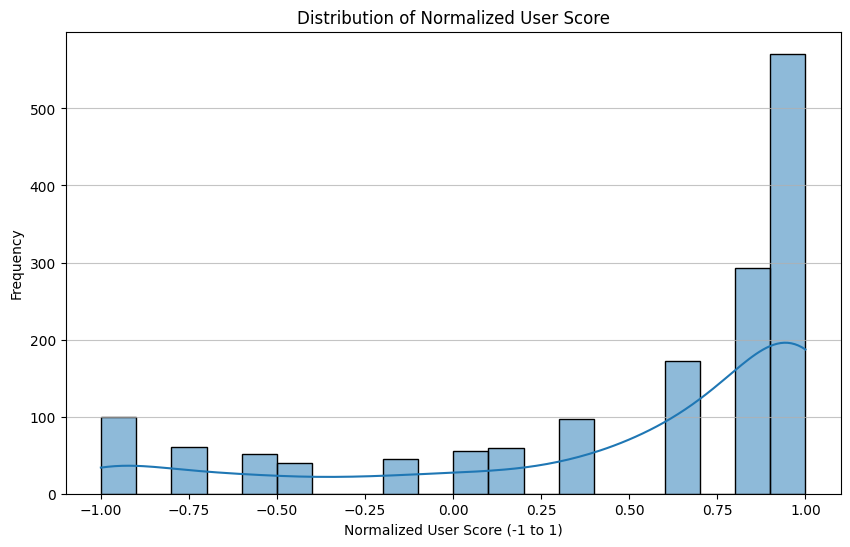

In [ ]:
# PLOT NORMALIZED USER SCORE DISTRIBUTION
plt.figure(figsize=(10, 6))
sns.histplot(df_en['normalized_user_score'], bins=20, kde=True)
plt.title('Distribution of Normalized User Score')
plt.xlabel('Normalized User Score (-1 to 1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Meta Score — Distribution, Missingness, Normalization

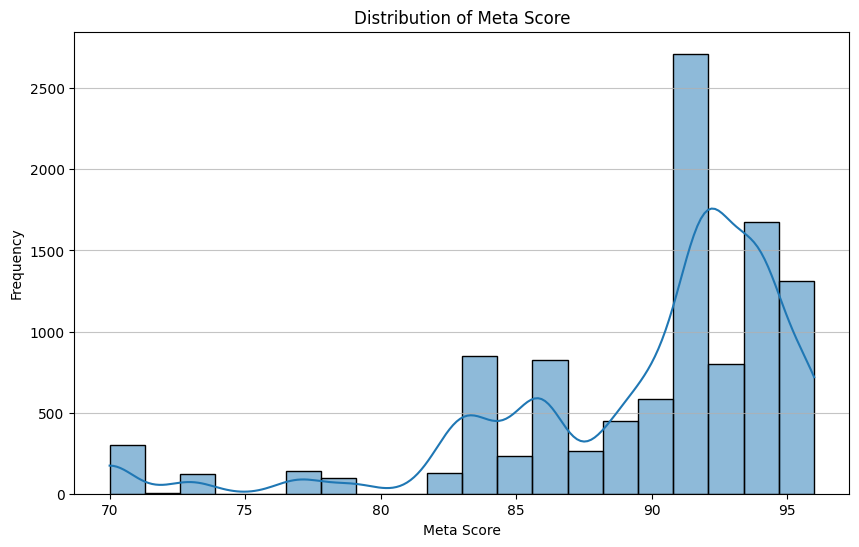

In [ ]:
# META SCORE DISTRIBUTION
plt.figure(figsize=(10, 6))
sns.histplot(df_en['meta_score'], bins=20, kde=True)
plt.title('Distribution of Meta Score')
plt.xlabel('Meta Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# MISSING VALUES
empty_meta_score_rows_count = df_en['meta_score'].isnull().sum()
print(f"Number of rows with empty meta_score: {empty_meta_score_rows_count}")

Number of rows with empty meta_score: 0


In [ ]:
# NORMALIZATION
# Meta score ranges 0–100 → Normalize to -1 to +1
df_en['normalized_meta_score'] = df_en['meta_score'].apply(
    lambda x: (x / 50) - 1 if pd.notna(x) else x
)

In [ ]:
print("Original Meta Score Description:")
print(df_en['meta_score'].describe())

print("\nNormalized Meta Score Description:")
print(df_en['normalized_meta_score'].describe())

print("\nFirst 5 rows with original and normalized meta scores:")
print(df_en[['meta_score', 'normalized_meta_score']].head())

Original Meta Score Description:
count    10490.000000
mean        89.817827
std          5.719046
min         70.000000
25%         86.000000
50%         92.000000
75%         94.000000
max         96.000000
Name: meta_score, dtype: float64

Normalized Meta Score Description:
count    10490.000000
mean         0.796357
std          0.114381
min          0.400000
25%          0.720000
50%          0.840000
75%          0.880000
max          0.920000
Name: normalized_meta_score, dtype: float64

First 5 rows with original and normalized meta scores:
   meta_score  normalized_meta_score
1          79                   0.58
2          79                   0.58
3          79                   0.58
4          79                   0.58
5          79                   0.58


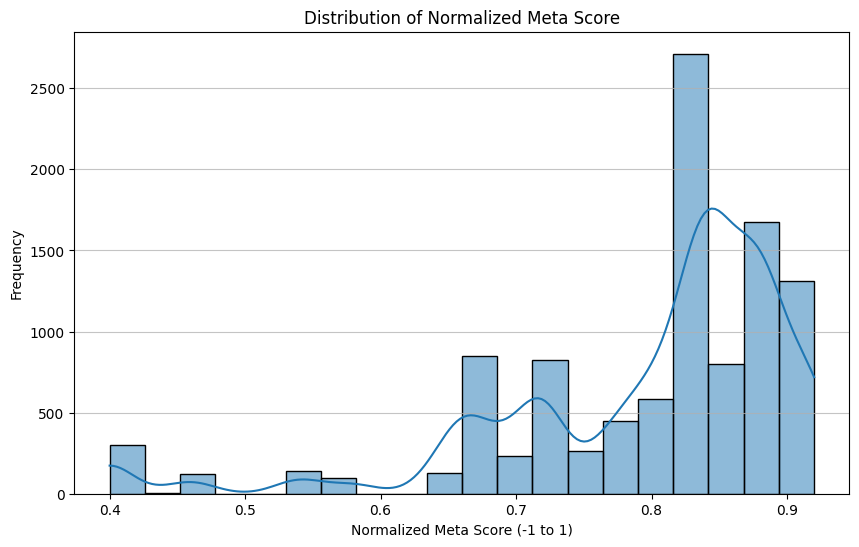

In [ ]:
# PLOT NORMALIZED META SCORE DISTRIBUTION
plt.figure(figsize=(10, 6))
sns.histplot(df_en['normalized_meta_score'], bins=20, kde=True)
plt.title('Distribution of Normalized Meta Score')
plt.xlabel('Normalized Meta Score (-1 to 1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Correlation Between User Score & Meta Score

In [ ]:
print("\nCorrelation between user_score and meta_score:")
print(df_en[['user_score', 'meta_score']].corr())


Correlation between user_score and meta_score:
            user_score  meta_score
user_score    1.000000    0.339488
meta_score    0.339488    1.000000


## Feature Engineering — Embeddings (updated for fuzzed pipeline)

In [ ]:
# Feature Engineering: Embeddings

!pip install gensim

import numpy as np
import gensim.downloader as api
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 25.7 MB/s eta 0:00:00


In [ ]:
# Helper: document -> avg embedding

def document_vector(tokens, model):
    """
    Converts list of tokens into a document vector using average word embeddings.
    Returns zero vector if no token appears in model vocabulary.
    """
    valid_tokens = [t for t in tokens if t in model.key_to_index]
    if not valid_tokens:
        return np.zeros(model.vector_size, dtype=np.float32)
    vectors = [model[t] for t in valid_tokens]
    return np.mean(vectors, axis=0)

### GloVe Twitter-100 (exploratory)

In [ ]:
# GloVe Twitter-100 (exploratory)

glove_twitter_model = api.load("glove-twitter-100")
print("GloVe Twitter dim:", glove_twitter_model.vector_size)

# Use current lemma column: df_en['lemmas']
%time glove_twitter_series = df_en['lemmas'].apply(lambda tokens: document_vector(tokens, glove_twitter_model))

glove_twitter_vectors = glove_twitter_series.tolist()
glove_twitter_df = pd.DataFrame(glove_twitter_vectors)
glove_twitter_df['normalized_meta_score'] = df_en['normalized_meta_score'].values
glove_twitter_df['normalized_user_score'] = df_en['normalized_user_score'].values

glove_twitter_df.shape
glove_twitter_df.head()

[==================================================] 100.0% 387.1/387.1MB downloaded
GloVe Twitter dim: 100
CPU times: user 747 ms, sys: 17 ms, total: 764 ms
Wall time: 753 ms


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,normalized_meta_score,normalized_user_score
0,0.037370,-0.050722,0.114951,0.028559,-0.034083,0.184299,0.280041,-0.064150,-0.013093,0.004541,...,-0.123310,-0.235231,0.091757,0.045171,0.159466,0.121641,0.004686,0.116024,0.58,0.8
1,0.125118,0.245152,-0.257396,-0.337886,0.106837,-0.533014,0.528140,-0.498586,0.099581,0.160891,...,-0.022818,-0.302128,0.257812,0.040836,0.093712,0.048749,0.047263,0.192510,0.58,0.8
2,0.108232,-0.002022,0.029573,-0.040775,0.066630,0.229670,0.229070,-0.112668,-0.049318,0.014015,...,-0.025201,-0.191367,0.168196,0.045560,0.172045,0.052197,-0.056274,-0.050225,0.58,0.8
3,0.196087,0.157842,-0.036191,-0.123042,0.006587,0.242781,0.336108,-0.246087,0.084609,0.119641,...,-0.161981,-0.175400,0.179325,-0.107172,0.137679,0.112815,-0.083573,-0.247342,0.58,1.0
4,0.087807,0.068218,-0.016640,-0.061066,0.017475,0.263181,0.243942,-0.110246,-0.043255,0.024512,...,-0.138837,-0.231835,0.157190,-0.036875,0.139296,0.000670,0.067111,-0.032608,0.58,1.0


### GloVe (GloVe-Wiki-Gigaword-50)

In [ ]:
# GloVe (glove-wiki-gigaword-50)

glove_model = api.load("glove-wiki-gigaword-50")
print("GloVe dim:", glove_model.vector_size)

%time glove_vec_series = df_en['lemmas'].apply(lambda toks: document_vector(toks, glove_model))
glove_vectors = np.stack(glove_vec_series.values)
glove_df = pd.DataFrame(glove_vectors)
glove_df['normalized_meta_score'] = df_en['normalized_meta_score'].values
glove_df['normalized_user_score'] = df_en['normalized_user_score'].values
display(glove_df.head())

[==================================================] 100.0% 66.0/66.0MB downloaded
GloVe dim: 50
CPU times: user 697 ms, sys: 24 ms, total: 721 ms
Wall time: 705 ms


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,normalized_meta_score,normalized_user_score
0,-0.017650,0.327503,-0.288138,0.178819,0.341182,0.086402,-0.342318,0.000953,-0.339633,0.302168,...,-0.235154,0.211931,-0.168031,0.229196,0.211951,-0.237491,-0.077992,0.153297,0.58,0.8
1,0.269453,0.023564,0.464728,-0.239462,-0.403933,0.060602,0.522346,-0.209542,0.463482,-0.226434,...,-0.070834,-0.088804,0.009118,0.281344,0.308635,0.415134,0.298133,0.158988,0.58,0.8
2,0.112587,0.143663,-0.197769,-0.009735,0.266433,0.143647,-0.029794,-0.048152,-0.120565,0.275415,...,-0.153986,0.157877,-0.092519,0.071385,0.259165,0.011341,-0.078163,0.200508,0.58,0.8
3,0.144403,0.128861,-0.153245,0.036706,0.351367,-0.007127,-0.338100,-0.052930,-0.100089,0.310292,...,-0.065188,0.307906,-0.019665,0.099745,0.266819,0.190412,0.025542,0.374955,0.58,1.0
4,-0.006996,0.144040,-0.046837,0.093780,0.226232,0.014154,-0.293878,-0.084246,-0.191803,0.263001,...,-0.104350,0.225986,-0.098611,0.197071,0.283306,-0.043100,-0.001585,0.204345,0.58,1.0


### Word2Vec (GoogleNews-300)

In [ ]:
# Word2Vec (GoogleNews-300)

w2v_model = api.load("word2vec-google-news-300")
print("Word2Vec dim:", w2v_model.vector_size)

%time w2v_vec_series = df_en['lemmas'].apply(lambda toks: document_vector(toks, w2v_model))
w2v_vectors = np.stack(w2v_vec_series.values)
w2v_df = pd.DataFrame(w2v_vectors)
w2v_df['normalized_meta_score'] = df_en['normalized_meta_score'].values
w2v_df['normalized_user_score'] = df_en['normalized_user_score'].values
display(w2v_df.head())

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec dim: 300
CPU times: user 1.33 s, sys: 13.9 ms, total: 1.35 s
Wall time: 1.55 s


,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,normalized_meta_score,normalized_user_score
0,0.111210,0.047688,-0.003629,0.088442,0.011473,0.023103,0.112080,-0.105780,0.054549,0.093847,...,-0.111505,-0.054471,-0.032409,-0.048724,-0.004918,-0.078580,-0.036023,0.012102,0.58,0.8
1,0.020581,-0.025488,0.028076,-0.085498,-0.042352,0.020911,0.031525,0.033203,0.063867,0.055176,...,-0.082617,-0.013074,0.138892,-0.060930,-0.036743,-0.145605,-0.044434,-0.165527,0.58,0.8
2,0.061387,0.030449,-0.018904,0.055971,-0.030876,0.051023,0.087925,-0.043354,0.087443,0.079993,...,-0.078967,-0.021968,-0.063234,-0.034530,0.023775,-0.068511,-0.020380,-0.010776,0.58,0.8
3,0.021819,-0.014282,-0.089703,0.117922,-0.012614,0.029187,0.118192,-0.043124,0.048264,0.072235,...,-0.066622,0.022878,-0.044630,-0.025327,0.030758,-0.084682,0.015694,-0.021048,0.58,1.0
4,0.066727,0.056280,0.006623,0.103179,-0.014734,0.019493,0.088069,-0.085631,0.077504,0.089927,...,-0.086584,-0.022798,-0.046634,-0.028132,0.001604,-0.073991,-0.005279,-0.012281,0.58,1.0


### FastText (wiki-news-subwords-300)

In [ ]:
# FastText (wiki-news-subwords-300)

ft_model = api.load("fasttext-wiki-news-subwords-300")
print("FastText dim:", ft_model.vector_size)

%time ft_vec_series = df_en['lemmas'].apply(lambda toks: document_vector(toks, ft_model))
ft_vectors = np.stack(ft_vec_series.values)
ft_df = pd.DataFrame(ft_vectors)
ft_df['normalized_meta_score'] = df_en['normalized_meta_score'].values
ft_df['normalized_user_score'] = df_en['normalized_user_score'].values
display(ft_df.head())

[==================================================] 100.0% 958.5/958.4MB downloaded
FastText dim: 300
CPU times: user 674 ms, sys: 8.06 ms, total: 682 ms
Wall time: 695 ms


,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,normalized_meta_score,normalized_user_score
0,-0.002879,-0.033031,0.007749,0.033483,-0.020847,-0.015623,-0.019773,-0.106775,0.013375,0.015212,...,-0.010670,-0.025295,0.030303,-0.017031,0.020178,0.010330,0.016402,0.007877,0.58,0.8
1,-0.018612,-0.061280,-0.031346,0.047051,-0.030000,-0.004357,-0.021541,-0.102432,-0.035625,0.021480,...,0.026464,0.020507,0.005393,-0.029301,-0.006887,0.035402,0.005956,-0.027462,0.58,0.8
2,-0.009324,-0.018679,0.014197,0.027543,-0.026951,-0.017409,-0.015121,-0.105972,0.006189,0.008922,...,-0.012371,-0.007051,0.019518,-0.008125,0.006848,0.009200,0.000674,-0.009839,0.58,0.8
3,0.000077,-0.001155,0.020250,0.013954,-0.028370,-0.014658,-0.005850,-0.114645,-0.017888,0.005975,...,-0.002689,-0.025843,0.026855,-0.012002,0.009128,0.003666,0.003867,-0.012370,0.58,1.0
4,-0.003787,-0.022734,0.005047,0.023862,-0.018310,-0.020433,-0.010800,-0.104027,0.004801,0.008535,...,-0.018756,-0.011704,0.029689,-0.015898,0.008875,-0.004979,0.020283,-0.000810,0.58,1.0


### Embedding Coverage Summary

In [ ]:
# Embedding Coverage Summary

def coverage_rate(vec_matrix):
    norms = np.linalg.norm(vec_matrix, axis=1)
    return np.mean(norms > 0)

summary_rows = []

for name, mat in [
    ("GloVe-50", glove_vectors),
    ("Word2Vec-300", w2v_vectors),
    ("FastText-300", ft_vectors),
]:
    summary_rows.append({
        "Embedding": name,
        "Dimensionality": mat.shape[1],
        "Doc Count": mat.shape[0],
        "Coverage (non-zero %)": 100 * coverage_rate(mat)
    })

emb_summary = pd.DataFrame(summary_rows)
emb_summary

,Embedding,Dimensionality,Doc Count,Coverage (non-zero %)
0,GloVe-50,50,10490,99.942803
1,Word2Vec-300,300,10490,99.942803
2,FastText-300,300,10490,99.942803


## Embedding Visualizations: PCA & t-SNE

In [ ]:
# Embedding Visualizations: PCA & t-SNE

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Create score bins based on normalized_meta_score
def bin_score(x):
    if pd.isna(x):
        return "missing"
    if x <= -0.2:
        return "low"
    elif x <= 0.2:
        return "medium"
    else:
        return "high"

df_en['meta_bin'] = df_en['normalized_meta_score'].apply(bin_score)

palette = {"low": "red", "medium": "orange", "high": "green", "missing": "gray"}

def pca_scatter(emb_matrix, title):
    pca = PCA(n_components=2, random_state=42)
    emb_2d = pca.fit_transform(emb_matrix)

    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        x=emb_2d[:, 0],
        y=emb_2d[:, 1],
        hue=df_en['meta_bin'],
        palette=palette,
        alpha=0.5,
        s=10
    )
    plt.title(title + f"\n(Explained variance: {pca.explained_variance_ratio_.sum():.2f})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.legend(title="Meta score bin", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

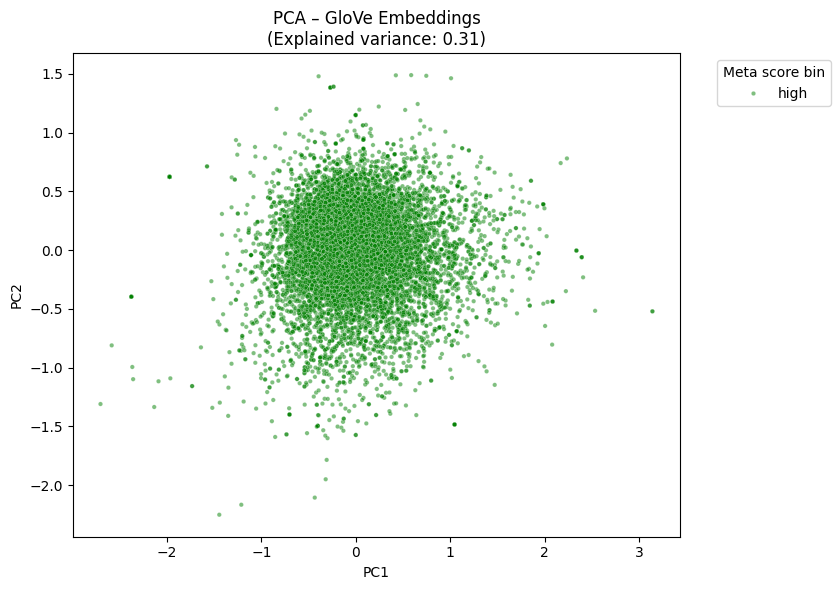

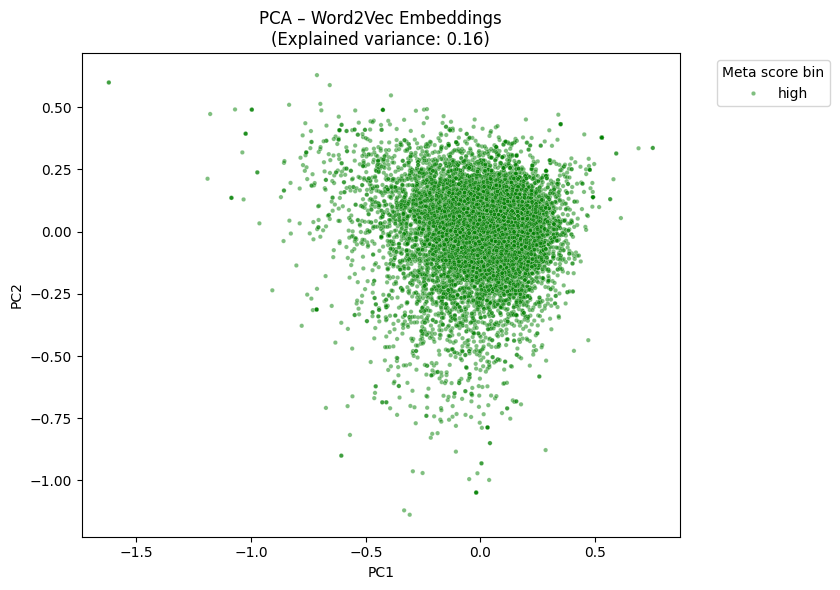

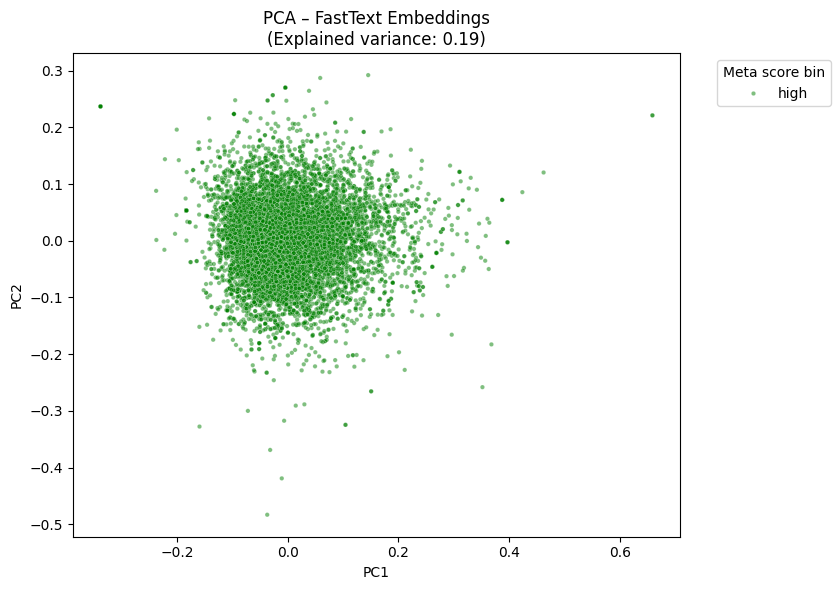

In [ ]:
# Run PCA for all embeddings
pca_scatter(glove_vectors, "PCA – GloVe Embeddings")
pca_scatter(w2v_vectors, "PCA – Word2Vec Embeddings")
pca_scatter(ft_vectors,  "PCA – FastText Embeddings")

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.357s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.051968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.303284
[t-SNE] KL divergence after 1000 iterations: 2.395347


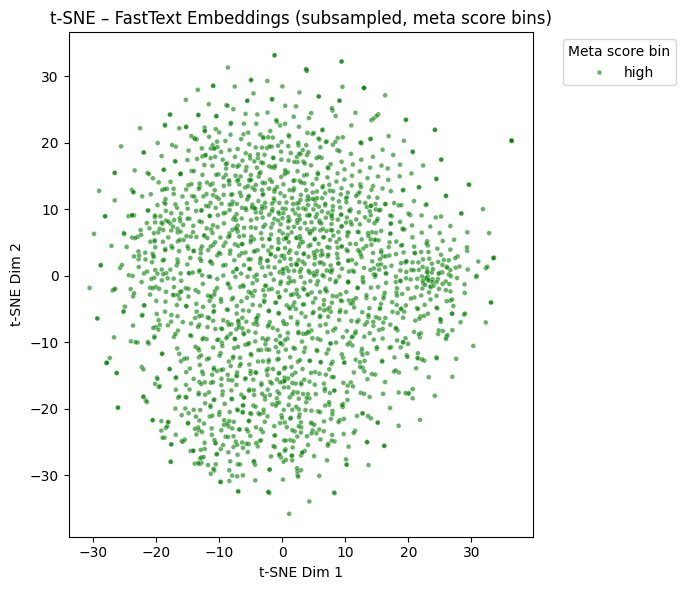

In [ ]:
# t-SNE Visualization (FastText only, subsample up to 2000 docs)
tsne_sample = min(2000, ft_vectors.shape[0])
tsne_idx = np.random.choice(ft_vectors.shape[0], tsne_sample, replace=False)

X_tsne = ft_vectors[tsne_idx]
y_tsne = df_en['meta_bin'].iloc[tsne_idx].reset_index(drop=True)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    verbose=1,
    random_state=42
)
X_emb_tsne = tsne.fit_transform(X_tsne)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    x=X_emb_tsne[:, 0],
    y=X_emb_tsne[:, 1],
    hue=y_tsne,
    palette=palette,
    alpha=0.6,
    s=12
)
plt.title("t-SNE – FastText Embeddings (subsampled, meta score bins)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Meta score bin", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# SENTIMENT ANALYSIS

In [ ]:
# Install Sentiment Tools

!pip install textblob

import pandas as pd
import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon (required)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Sentiment Analysis Setup
!pip install textblob

from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# Create sentiment dataframe
df_sa = df_en[['normalized_meta_score',
               'normalized_user_score',
               'review_expanded']].copy()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# TextBlob polarity & subjectivity
df_sa['polarity'] = df_sa['review_expanded'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_sa['subjectivity'] = df_sa['review_expanded'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
# VADER compound score
sia = SentimentIntensityAnalyzer()
df_sa['compound'] = df_sa['review_expanded'].apply(lambda x: sia.polarity_scores(x)['compound'])

df_sa.head()

,normalized_meta_score,normalized_user_score,review_expanded,polarity,subjectivity,compound
1,0.58,0.8,"I loved this game the whole way through, even ...",0.196257,0.581150,0.9709
2,0.58,0.8,[SPOILER ALERT This review contains spoilers.],0.000000,0.000000,0.4466
3,0.58,0.8,"the game stands out, in my opinion, as the bes...",0.223752,0.482850,0.9947
4,0.58,1.0,"I normally do not enjoy these kind of games, b...",0.296667,0.625556,0.9679
5,0.58,1.0,I have played Hyrule Warriors on the 3DS and n...,0.181261,0.556989,0.9982


## Correlation:

In [ ]:
df_sa[['polarity','subjectivity','compound','normalized_meta_score']].corr()

,polarity,subjectivity,compound,normalized_meta_score
polarity,1.000000,0.199966,0.499722,0.099377
subjectivity,0.199966,1.000000,0.061523,0.022239
compound,0.499722,0.061523,1.000000,0.094891
normalized_meta_score,0.099377,0.022239,0.094891,1.000000


In [ ]:
df_sa[['polarity','subjectivity','compound','normalized_user_score']].corr()

,polarity,subjectivity,compound,normalized_user_score
polarity,1.000000,0.199966,0.499722,0.503865
subjectivity,0.199966,1.000000,0.061523,0.017643
compound,0.499722,0.061523,1.000000,0.543854
normalized_user_score,0.503865,0.017643,0.543854,1.000000


# Topic Modeling

In [ ]:
# Create df_lemmas for topic modeling with fuzzed + cleaned text
df_lemmas = df_en[['lemmas']].copy()

In [ ]:
# Review_Final = string version of lemmas (clean_text already comes from fuzzed reviews)
df_lemmas['Review_Final'] = df_en['clean_text']

In [ ]:
# Inspect output
df_lemmas.head()

,lemmas,Review_Final
1,"[love, game, way, despise, age, calamity, game...",love game way despise age calamity game phenom...
2,"[spoiler, alert, review, contain, spoiler]",spoiler alert review contain spoiler
3,"[game, stand, opinion, good, entry, hyrule, wa...",game stand opinion good entry hyrule warrior s...
4,"[normally, enjoy, kind, game, surprise, work, ...",normally enjoy kind game surprise work perfect...
5,"[play, hyrule, warrior, far, like, zelda, huge...",play hyrule warrior far like zelda huge zelda ...


In [ ]:
# Check for missing values
df_lemmas.isnull().sum()

,0
lemmas,0
Review_Final,0


In [ ]:
# Drop any null rows to avoid LDA/LSA crashes
df_lemmas = df_lemmas.dropna(subset=['lemmas', 'Review_Final'])

## Bag-of-Words (Frequency BOW)

In [ ]:
# 1.1 FREQUENCY BAG-OF-WORDS (BOW)
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer using your topic-modeling parameters
vectorize_freq = CountVectorizer(
    max_features=1000,
    stop_words="english",
    max_df=0.75,
    min_df=0.01
)

In [ ]:
# Fit-transform on the cleaned, fuzzed text
matrix_freq = vectorize_freq.fit_transform(df_lemmas['Review_Final'])

In [ ]:
# Convert sparse matrix → DataFrame for inspection
df_bow_freq = pd.DataFrame(
    matrix_freq.toarray(),
    index=df_lemmas.index,
    columns=vectorize_freq.get_feature_names_out()
)

In [ ]:
print("Shape of Frequency BOW matrix:", df_bow_freq.shape)
df_bow_freq.head()

Shape of Frequency BOW matrix: (10490, 555)


,aaa,ability,able,absolute,absolutely,act,action,actual,actually,add,...,wonderful,word,work,world,worth,write,wrong,yakuza,year,yes
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


## One-Hot BOW (Binary)

In [ ]:
# One-Hot (Binary) Bag-of-Words Representation


from sklearn.feature_extraction.text import CountVectorizer

# Binary Bag-of-Words vectorizer
vectorize_BOW = CountVectorizer(
    max_features=1000,
    stop_words="english",
    max_df=0.75,
    min_df=0.01,
    binary=True
)

In [ ]:
# Fit on Review_Final (the fuzzed + cleaned text)
matrix_BOW = vectorize_BOW.fit_transform(df_lemmas['Review_Final'])

In [ ]:
# Convert into DataFrame
df_BOW = pd.DataFrame(
    matrix_BOW.toarray(),
    index=df_lemmas.index,
    columns=vectorize_BOW.get_feature_names_out()
)

df_BOW.head(), df_BOW.shape

(   aaa  ability  able  absolute  absolutely  act  action  actual  actually  \
 1    0        0     0         0           0    0       0       0         0   
 2    0        0     0         0           0    0       0       0         0   
 3    0        0     0         0           1    0       0       0         1   
 4    0        0     0         0           0    0       0       0         0   
 5    0        0     0         0           0    0       0       0         0   
 
    add  ...  wonderful  word  work  world  worth  write  wrong  yakuza  year  \
 1    0  ...          0     0     0      0      0      0      0       0     0   
 2    0  ...          0     0     0      0      0      0      0       0     0   
 3    1  ...          0     0     1      0      1      0      0       0     0   
 4    0  ...          0     0     1      0      0      0      0       0     0   
 5    0  ...          0     0     0      1      1      0      0       0     0   
 
    yes  
 1    0  
 2    0  
 3    

## TF-IDF Matrix Code

In [ ]:
# TF-IDF Matrix (using fuzzed + cleaned text)

from sklearn.feature_extraction.text import TfidfVectorizer

# Step: Create TF-IDF vectorizer
vectorize_tf = TfidfVectorizer(
    stop_words="english",
    max_features=1000,
    max_df=0.75,
    min_df=0.01,
    smooth_idf=True
)

In [ ]:
# Fit + transform on Review_Final (cleaned + fuzzed text)
%time
matrix_tfidf = vectorize_tf.fit_transform(df_lemmas['Review_Final'])

CPU times: user 124 µs, sys: 0 ns, total: 124 µs
Wall time: 135 µs


In [ ]:
# Step: Convert TF-IDF sparse matrix → DataFrame
df_tfidf = pd.DataFrame(
    matrix_tfidf.toarray(),
    index=df_lemmas.index,
    columns=vectorize_tf.get_feature_names_out()
)

df_tfidf.head(3)

,aaa,ability,able,absolute,absolutely,act,action,actual,actually,add,...,wonderful,word,work,world,worth,write,wrong,yakuza,year,yes
1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.07351,0.0,0.0,0.0,0.080013,0.071939,...,0.0,0.0,0.071558,0.0,0.075733,0.0,0.0,0.0,0.0,0.0


## LSA on BOW

In [ ]:
# LSA with BOW (Sklearn TruncatedSVD)

from sklearn.decomposition import TruncatedSVD

# Step 1: Build One-Hot BOW if you haven't already
vectorize_BOW = CountVectorizer(
    max_features=1000,
    stop_words="english",
    max_df=0.75,
    min_df=0.01,
    binary=True
)

In [ ]:
# Fit + transform
matrix_BOW = vectorize_BOW.fit_transform(df_lemmas['Review_Final'])

In [ ]:
# Run LSA
n_topics = 8

svd_model_bow = TruncatedSVD(
    n_components=n_topics,
    algorithm='randomized',
    n_iter=100,
    random_state=122
)

In [ ]:
%time svd_model_bow.fit(matrix_BOW)

CPU times: user 1.71 s, sys: 6.12 ms, total: 1.72 s
Wall time: 1.42 s


TruncatedSVD(n_components=8, n_iter=100, random_state=122)

In [ ]:
# Display top 15 words per topic
for i, component in enumerate(svd_model_bow.components_):
    terms_comp = zip(vectorize_BOW.get_feature_names_out(), component)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:15]

    print(f"\nTopic {i}: ")
    print(" ".join([t[0] for t in sorted_terms]))


Topic 0: 
play good like story feel time character gameplay great fun world new combat way experience

Topic 1: 
good play story gameplay amazing graphic great love fun masterpiece music year goty perfect jrpg

Topic 2: 
story gameplay character combat great music world amazing experience visual narrative soundtrack masterpiece graphic turn

Topic 3: 
good boss design world fight enemy level dlc difficulty challenge soul area weapon mechanic exploration

Topic 4: 
like story great thing bad lot think feel fun pretty boring people end graphic look

Topic 5: 
like feel gameplay experience good masterpiece visual make narrative atmosphere stunning year love truly create

Topic 6: 
gameplay great fun graphic design like amazing boss level challenge sound feel soul visual beautiful

Topic 7: 
fun world boss design like level fight play open enemy story gameplay interesting challenge hour


## LSA on TF-IDF

In [ ]:
# LSA on TF-IDF  (Updated for fuzzed Review_Final)

from sklearn.decomposition import TruncatedSVD

# Use the same n_topics as before
n_topics = 8

svd_model_tfidf = TruncatedSVD(
    n_components=n_topics,
    algorithm='randomized',
    n_iter=100,
    random_state=122
)

In [ ]:
%time svd_model_tfidf.fit(matrix_tfidf)

CPU times: user 1.7 s, sys: 0 ns, total: 1.7 s
Wall time: 1.29 s


TruncatedSVD(n_components=8, n_iter=100, random_state=122)

In [ ]:
# Print top 15 most important TF-IDF words for each latent topic
for i, component in enumerate(svd_model_tfidf.components_):
    terms_comp = zip(vectorize_tf.get_feature_names_out(), component)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:15]

    print(f"\nLSA Topic {i}:")
    for t in sorted_terms:
        print(t[0], end=" ")
    print("\n")


LSA Topic 0:
good play story like great time feel gameplay character fun love amazing world combat new 


LSA Topic 1:
good play year amazing graphic masterpiece goty remake jrpg horror probably life history resident evil 


LSA Topic 2:
great story gameplay amazing character graphic music combat beautiful perfect soundtrack art awesome incredible fantastic 


LSA Topic 3:
play great love amazing fun hour year time recommend absolutely enjoy want buy friend playing 


LSA Topic 4:
remake original masterpiece soul great new perfect horror graphic atmosphere amazing fan resident evil team 


LSA Topic 5:
great boss good like time fight dlc soul bad fun new thing car lot pretty 


LSA Topic 6:
like feel love story persona great character bad remake turn original good think yakuza review 


LSA Topic 7:
love boss great fun dlc like soul good cat level elden ring beautiful lot nice 



## Prepare Gensim Corpus

In [ ]:
# Prepare Gensim Corpus (UPDATED for fuzzed & cleaned text)
# required imports
from gensim import corpora, models

In [ ]:
# texts = list of token lists (lemmas already come from fuzzed reviews)
texts = df_lemmas['lemmas'].tolist()

In [ ]:
# id2word: mapping token_id → token
id2word = corpora.Dictionary(texts)

In [ ]:
# BOW corpus: list of list of (token_id, count)
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
print(texts[0][:20])
print(corpus[0][:10])

['love', 'game', 'way', 'despise', 'age', 'calamity', 'game', 'phenomenal', 'tell', 'unknown', 'botw', 'totk', 'lore', 'think', 'game', 'perfect', 'time', 'goodbye', 'botw', 'era']
[(0, 1), (1, 1), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


## LSA (BOW) with Gensim

In [ ]:
# Gensim LSA (BOW)

def create_gensim_lsa(corpus, id2word, n_topics, n_words=15):
    """
    Create a Gensim LSA model and print topics.
    """
    lsa_model = models.LsiModel(
        corpus,
        id2word=id2word,
        num_topics=n_topics
    )

    topics = lsa_model.show_topics(
        num_topics=n_topics,
        num_words=n_words,
        formatted=True
    )

    for topic in topics:
        print("Topic", topic[0], ":", topic[1])

    return lsa_model

In [ ]:
n_topics = 8   # same as before
lsi_model_bow = create_gensim_lsa(corpus, id2word, n_topics=n_topics, n_words=15)

Topic 0 : 0.842*"game" + 0.173*"like" + 0.158*"play" + 0.141*"good" + 0.135*"story" + 0.121*"feel" + 0.109*"character" + 0.109*"time" + 0.076*"gameplay" + 0.072*"great" + 0.071*"world" + 0.069*"new" + 0.065*"boss" + 0.064*"fun" + 0.059*"combat"
Topic 1 : -0.481*"game" + 0.401*"feel" + 0.345*"like" + 0.258*"story" + 0.210*"character" + 0.160*"boss" + 0.156*"time" + 0.123*"combat" + 0.114*"world" + 0.112*"fight" + 0.109*"way" + 0.107*"new" + 0.100*"great" + 0.092*"gameplay" + 0.091*"thing"
Topic 2 : -0.548*"story" + -0.390*"good" + -0.304*"character" + 0.292*"boss" + 0.251*"like" + 0.231*"feel" + -0.168*"gameplay" + -0.148*"play" + 0.112*"player" + -0.106*"great" + -0.099*"combat" + 0.086*"world" + 0.080*"game" + 0.079*"time" + 0.078*"soul"
Topic 3 : 0.520*"good" + 0.508*"play" + 0.275*"like" + -0.252*"story" + -0.206*"character" + -0.172*"world" + -0.137*"game" + -0.108*"combat" + -0.101*"gameplay" + -0.098*"experience" + 0.086*"thing" + 0.084*"lot" + -0.072*"narrative" + 0.069*"bad" + 

## LSA (TF-IDF) + Coherence Score

In [ ]:
# Required imports for Gensim LSA + Coherence
from gensim.models import CoherenceModel

In [ ]:
# Build TF-IDF model on BOW corpus
tfidf = models.TfidfModel(corpus)

corpus_tfidf = tfidf[corpus]

In [ ]:
# LSA on TF-IDF corpus
lsi_model_tfidf = models.LsiModel(
    corpus=corpus_tfidf,
    id2word=id2word,
    num_topics=n_topics
)

In [ ]:
# Coherence for both LSA versions
coherence_model_lsi_idf = CoherenceModel(
    model=lsi_model_tfidf,
    texts=texts,
    dictionary=id2word,
    coherence='c_v'
)
coh_lsi_idf = coherence_model_lsi_idf.get_coherence()

coherence_model_lsi_bow = CoherenceModel(
    model=lsi_model_bow,
    texts=texts,
    dictionary=id2word,
    coherence='c_v'
)
coh_lsi_bow = coherence_model_lsi_bow.get_coherence()

In [ ]:
print("LSA (BOW) coherence:", coh_lsi_bow)
print("LSA (TF-IDF) coherence:", coh_lsi_idf)

LSA (BOW) coherence: 0.3808482459629961
LSA (TF-IDF) coherence: 0.3568609698862575


## Coherence vs Number of Topics

In [ ]:
# Scan coherence over different topic numbers (LSA)
def compute_coherence_scores(id2word, corpus, texts, stop, start=2, step=2,
                             coherence_measure='c_v'):
    coherence_scores = []
    model_list = []

    for n_topics in range(start, stop + 1, step):
        lsa_model = models.LsiModel(
            corpus,
            id2word=id2word,
            num_topics=n_topics
        )

        model_list.append(lsa_model)

        coherence_model_lsa = CoherenceModel(
            model=lsa_model,
            texts=texts,
            dictionary=id2word,
            coherence=coherence_measure
        )

        coherence_scores.append(coherence_model_lsa.get_coherence())

    return model_list, coherence_scores

In [ ]:
lsa_models, lsa_scores = compute_coherence_scores(
    id2word=id2word,
    corpus=corpus_tfidf,
    texts=texts,
    stop=20,
    start=2,
    step=2,
    coherence_measure='c_v'
)

In [ ]:
# Clean formatted output
for k, score in zip(range(2, 21, 2), lsa_scores):
    print(f"Topics = {k}: Coherence = {score:.4f}")

Topics = 2: Coherence = 0.3554
Topics = 4: Coherence = 0.3851
Topics = 6: Coherence = 0.3507
Topics = 8: Coherence = 0.4055
Topics = 10: Coherence = 0.3620
Topics = 12: Coherence = 0.3520
Topics = 14: Coherence = 0.3433
Topics = 16: Coherence = 0.3182
Topics = 18: Coherence = 0.3305
Topics = 20: Coherence = 0.3305


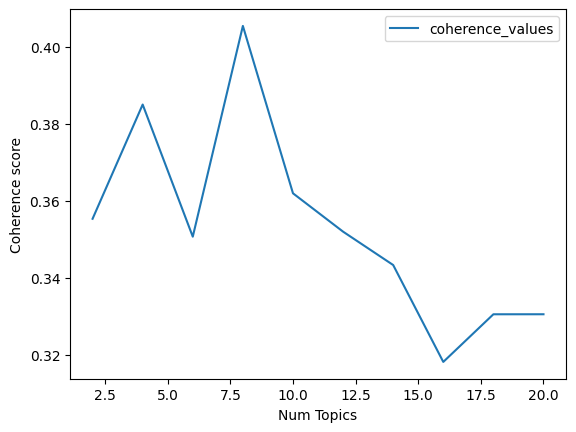

In [ ]:
# Plot coherence values
x = range(2, 21, 2)
plt.plot(x, lsa_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values",), loc='best')
plt.show()

Our coherence evaluation across topic numbers (2–20, step=2) shows that:

Coherence peaks at 8 topics (≈ 0.4055), which is the highest across the entire range.

Topic counts above 10 show progressive coherence decline, indicating reduced semantic stability.

Topic counts below 6 capture broad themes but miss finer distinctions within the review corpus.

Conclusion – Best LSA Topic Count: 8 Topics

Based on the coherence curve, 8 topics provide the best balance between:

semantic clarity

interpretability

model coherence

This suggests that the cleaned, fuzzed, English-only game review corpus naturally organizes into eight distinct latent themes under LSA.

## LDA Topic Modeling

In [ ]:
# IMPORT REQUIRED GENSIM PARTS
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
import gensim

In [ ]:
# Prepare Bigrams & Corpus

# texts = list of token lists from fuzzed + cleaned lemmas
texts = df_lemmas['lemmas'].tolist()

In [ ]:
# Build bigram model (find common 2-word phrases)
bigram = Phrases(texts, min_count=40)
bigram_phraser = Phraser(bigram)

In [ ]:
# Apply bigram model
texts_lda = bigram_phraser[texts]

In [ ]:
# Build dictionary of all tokens
id2word_lda = Dictionary(texts_lda)

In [ ]:
# Remove very rare words (appears <40 docs) and too common (>75%)
id2word_lda.filter_extremes(no_below=40, no_above=0.75)

In [ ]:
# Convert each document into BOW representation
corpus_lda = [id2word_lda.doc2bow(text) for text in texts_lda]

In [ ]:
# Inspect sample
print("Sample tokens:", texts_lda[0][:20])
print("Sample BOW:", corpus_lda[0][:10])
print("Dictionary size:", len(id2word_lda))

Sample tokens: ['love', 'game', 'way', 'despise', 'age', 'calamity', 'game', 'phenomenal', 'tell', 'unknown', 'botw', 'totk', 'lore', 'think', 'game', 'perfect', 'time', 'goodbye', 'botw', 'era']
Sample BOW: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
Dictionary size: 1293


## Train Base LDA Model (e.g., 8 topics)

In [ ]:
# Train initial LDA model (8 topics)
num_topics = 8
chunksize = 100
passes = 20
iterations = 400
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus_lda,
    id2word=id2word_lda,
    chunksize=chunksize,
    passes=passes,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    per_word_topics=True,
    eval_every=eval_every
)

In [ ]:
# Print top words per topic
for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=15, formatted=True):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.058*"love" + 0.037*"end" + 0.032*"level" + 0.031*"interesting" + 0.027*"design" + 0.024*"pretty" + 0.020*"music" + 0.020*"ninja_gaiden" + 0.019*"especially" + 0.018*"hard" + 0.017*"main" + 0.017*"boss" + 0.017*"weapon" + 0.016*"run" + 0.015*"art"
Topic 1: 0.114*"moment" + 0.084*"write" + 0.062*"live" + 0.059*"bring" + 0.036*"mix" + 0.034*"forget" + 0.034*"single" + 0.032*"stick" + 0.031*"begin" + 0.030*"emotional" + 0.028*"spoiler" + 0.027*"confuse" + 0.027*"horrible" + 0.022*"clever" + 0.021*"color"
Topic 2: 0.031*"new" + 0.031*"feel" + 0.024*"time" + 0.022*"way" + 0.021*"world" + 0.016*"make" + 0.016*"player" + 0.015*"original" + 0.015*"action" + 0.014*"feel_like" + 0.014*"enemy" + 0.013*"take" + 0.013*"overall" + 0.012*"find" + 0.011*"come"
Topic 3: 0.065*"remake" + 0.061*"horror" + 0.059*"yakuza" + 0.030*"developer" + 0.030*"style" + 0.028*"quality" + 0.028*"hope" + 0.021*"studio" + 0.021*"modern" + 0.021*"gaming" + 0.020*"annoying" + 0.020*"silent_hill" + 0.017*"improve

## Visualize Topics with pyLDAvis

In [ ]:
# Install pyLDAvis (quiet mode)
!pip install pyLDAvis==3.4.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.6 MB/s eta 0:00:00


In [ ]:
# Suppress Deprecation warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Imports required for visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
# Enable notebook display
pyLDAvis.enable_notebook()

In [ ]:
# Prepare the visualization
vis = gensimvis.prepare(lda_model, corpus_lda, id2word_lda)

In [ ]:
# Show visual output
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.236263  0.053568       1        1  26.327867
2      0.180708 -0.065027       2        1  26.211684
5      0.242150 -0.115443       3        1  16.531521
0     -0.057697  0.427122       4        1  12.215414
6     -0.200785 -0.149028       5        1   7.456107
3     -0.165710 -0.052911       6        1   4.842605
7     -0.147549 -0.073373       7        1   4.429127
1     -0.087381 -0.024908       8        1   1.985675, topic_info=              Term         Freq        Total Category  logprob  loglift
8             like  4008.000000  4008.000000  Default  30.0000  30.0000
100          story  4796.000000  4796.000000  Default  29.0000  29.0000
7             good  4796.000000  4796.000000  Default  28.0000  28.0000
88            play  5023.000000  5023.000000  Default  27.0000  27.0000
10            love  1881.000000  1881.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
557            put    74.019329    74.854058   Topic8  -4.2725   3.9080
718    predecessor    67.579563    68.414382   Topic8  -4.3635   3.9069
1152          door    65.763989    66.599251   Topic8  -4.3907   3.9066
1222  entertaining    60.098620    60.933339   Topic8  -4.4808   3.9054
1087         serve    59.326324    60.160982   Topic8  -4.4937   3.9052

[290 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
27        1  0.997741  absolutely
807       6  0.993499         act
178       2  0.999644      action
28        3  0.997049    actually
29        2  0.997886         add
...     ...       ...         ...
347       8  0.993485      worthy
298       8  0.998918       write
1269      6  0.999391      yakuza
301       1  0.095038        year
301       3  0.904450        year

[273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 1, 7, 4, 8, 2])

## Coherence Evaluation + Final LDA Model

In [ ]:
# LDA Coherence Evaluation
def compute_lda_coherence_scores(id2word, texts, corpus, stop, start=2, step=2,
                                 coherence_measure='c_v'):
    coherence_scores = []
    model_list = []

    for n_topics in range(start, stop + 1, step):
        chunksize = 100
        passes = 20
        iterations = 400
        eval_every = None

        lda_model_temp = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=n_topics,
            random_state=100,
            chunksize=chunksize,
            passes=passes,
            alpha='symmetric',
            eta='symmetric',
            iterations=iterations,
            gamma_threshold=0.001,
            per_word_topics=True,
            eval_every=eval_every
        )

        model_list.append(lda_model_temp)

        coherence_model_lda = CoherenceModel(
            model=lda_model_temp,
            texts=texts,
            dictionary=id2word,
            coherence=coherence_measure
        )

        coherence_scores.append(coherence_model_lda.get_coherence())

    return model_list, coherence_scores

In [ ]:
# Run coherence scoring
lda_models, lda_scores = compute_lda_coherence_scores(
    id2word=id2word_lda,
    texts=texts_lda,
    corpus=corpus_lda,
    stop=14,
    start=2,
    step=2,
    coherence_measure='c_v'
)

In [ ]:
# Print results cleanly
for k, score in zip(range(2, 21, 2), lda_scores):
    print(f"Topics = {k}: Coherence = {score:.4f}")

Topics = 2: Coherence = 0.4051
Topics = 4: Coherence = 0.4187
Topics = 6: Coherence = 0.3427
Topics = 8: Coherence = 0.3380
Topics = 10: Coherence = 0.3427
Topics = 12: Coherence = 0.3393
Topics = 14: Coherence = 0.3345


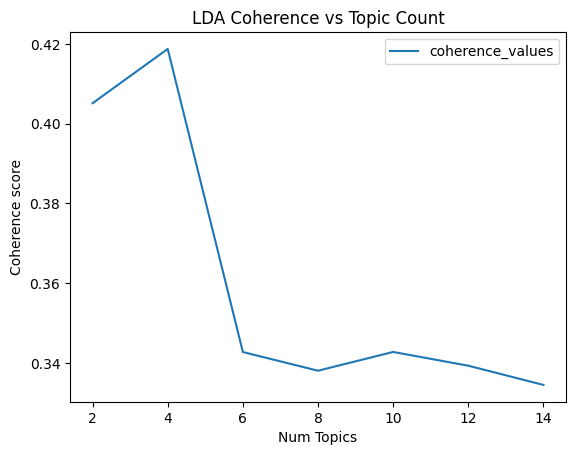

In [ ]:
# Plot LDA coherence vs topic number

x = range(2, 15, 2)
plt.plot(x, lda_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("LDA Coherence vs Topic Count")
plt.legend(("coherence_values",), loc='best')
plt.show()

In [ ]:
# Train final LDA model
best_topics = 4

lda_model_final = gensim.models.ldamodel.LdaModel(
    corpus=corpus_lda,
    id2word=id2word_lda,
    chunksize=chunksize,
    passes=passes,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=best_topics,
    per_word_topics=True,
    eval_every=eval_every
)


In [ ]:
# Show final topics
for idx, topic in lda_model_final.show_topics(num_topics=best_topics, num_words=15, formatted=True):
    print(f"Final Topic {idx}: {topic}")

Final Topic 0: 0.036*"feel" + 0.027*"new" + 0.026*"experience" + 0.024*"world" + 0.024*"character" + 0.018*"player" + 0.014*"series" + 0.014*"make" + 0.012*"mechanic" + 0.011*"narrative" + 0.010*"short" + 0.009*"especially" + 0.008*"real" + 0.008*"add" + 0.008*"plot"
Final Topic 1: 0.058*"bad" + 0.026*"boring" + 0.024*"moment" + 0.023*"ninja_gaiden" + 0.021*"fight" + 0.021*"boss" + 0.020*"run" + 0.019*"art" + 0.017*"leave" + 0.016*"style" + 0.014*"complete" + 0.014*"reason" + 0.012*"terrible" + 0.012*"extremely" + 0.012*"slow"
Final Topic 2: 0.055*"story" + 0.055*"good" + 0.047*"play" + 0.032*"great" + 0.032*"gameplay" + 0.026*"fun" + 0.022*"love" + 0.020*"puzzle" + 0.019*"well" + 0.017*"combat" + 0.017*"graphic" + 0.013*"original" + 0.013*"amazing" + 0.013*"action" + 0.012*"level"
Final Topic 3: 0.043*"like" + 0.026*"time" + 0.016*"thing" + 0.016*"way" + 0.014*"get" + 0.014*"year" + 0.013*"lot" + 0.013*"look" + 0.012*"go" + 0.012*"hour" + 0.012*"want" + 0.012*"end" + 0.012*"think" + 0

In [ ]:
# pyLDAvis Visualization
pyLDAvis.enable_notebook()
vis_final = pyLDAvis.gensim.prepare(lda_model_final, corpus_lda, id2word_lda)
vis_final

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.138339  0.367293       1        1  33.852970
2      0.173533 -0.165030       2        1  32.361169
0      0.100679 -0.205788       3        1  23.903027
1     -0.412551  0.003525       4        1   9.882834, topic_info=              Term         Freq        Total Category  logprob  loglift
100          story  4778.000000  4778.000000  Default  30.0000  30.0000
7             good  4777.000000  4777.000000  Default  29.0000  29.0000
8             like  3934.000000  3934.000000  Default  28.0000  28.0000
481            bad  1526.000000  1526.000000  Default  27.0000  27.0000
88            play  4921.000000  4921.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
818          shoot   199.210680   199.998514   Topic4  -4.8873   2.3104
630           push   199.719744   200.516794   Topic4  -4.8847   2.3104
378         follow   199.691037   200.489434   Topic4  -4.8849   2.3104
1189  ninja_gaiden   607.720311   658.530055   Topic4  -3.7719   2.2341
611          build   302.580925   413.742919   Topic4  -4.4693   2.0015

[188 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
27        2  0.997649  absolutely
178       2  0.999344      action
28        1  0.997456    actually
29        1  0.009293         add
29        3  0.990631         add
...     ...       ...         ...
1269      1  0.989002      yakuza
1269      2  0.004031      yakuza
1269      3  0.004031      yakuza
1269      4  0.002688      yakuza
301       1  0.999099        year

[197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

# Supervised Learning

In [ ]:
df_en.columns

Index(['game', 'game_name', 'meta_score', 'user_score', 'avg_user_score',
       'text', 'lang', 'review_expanded', 'review_tokens', 'clean_tokens',
       'pos_tags', 'lemmas', 'clean_text', 'len_tokens', 'len_clean_tokens',
       'lexical_diversity', 'processed_token_count', 'normalized_user_score',
       'normalized_meta_score', 'meta_bin'],
      dtype='object')

In [ ]:
df_en[['clean_text','normalized_meta_score','meta_bin']].isnull().sum()

,0
clean_text,0
normalized_meta_score,0
meta_bin,0


In [ ]:
df_en['meta_bin'].value_counts(normalize=True)

,proportion
meta_bin,
high,1.0


In [ ]:
df_en['meta_score'].describe()
df_en['meta_score'].value_counts().head(20)

for t in [70, 75, 80, 85]:
    print(f"Threshold {t}: proportion high = {(df_en['meta_score'] >= t).mean():.3f}")

Threshold 70: proportion high = 1.000
Threshold 75: proportion high = 0.959
Threshold 80: proportion high = 0.937
Threshold 85: proportion high = 0.844


In [ ]:
# SUPERVISED LEARNING SETUP
# Predict high vs non-high critic scores using fuzzed & cleaned text

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# 1. Use df_en (our main cleaned + fuzzed dataset)

# Check required columns exist
print(df_en.columns)

Index(['game', 'game_name', 'meta_score', 'user_score', 'avg_user_score',
       'text', 'lang', 'review_expanded', 'review_tokens', 'clean_tokens',
       'pos_tags', 'lemmas', 'clean_text', 'len_tokens', 'len_clean_tokens',
       'lexical_diversity', 'processed_token_count', 'normalized_user_score',
       'normalized_meta_score', 'meta_bin', 'target_high_meta'],
      dtype='object')


In [ ]:
# 2. Create binary target based on meta_score

# Good threshold = 85 (avoids collapse & matches critic definition)
THRESHOLD = 85

df_en["target_high_meta"] = (df_en["meta_score"] >= THRESHOLD).astype(int)

print("\nTarget distribution (1 = high-quality):")
print(df_en["target_high_meta"].value_counts(normalize=True))


Target distribution (1 = high-quality):
target_high_meta
1    0.844042
0    0.155958
Name: proportion, dtype: float64


In [ ]:
# Features for supervised learning

X = df_en["clean_text"]
y = df_en["target_high_meta"]

In [ ]:
# Vectorize text (TF-IDF)
tfidf = TfidfVectorizer(
    stop_words="english",
    max_df=0.75,
    min_df=0.01,
    max_features=5000
)

X_tfidf = tfidf.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (10490, 555)


In [ ]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (8392, 555)
Test size: (2098, 555)


In [ ]:
# Helper function (same as before)

def train_and_evaluate(model_name, estimator, param_grid):
    print(f"\n=============================")
    print(f"Model: {model_name}")
    print("=============================")

    grid = GridSearchCV(
        estimator,
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print("\nBest params:", grid.best_params_)

    y_pred = best_model.predict(X_test)

    if hasattr(best_model, "predict_proba"):
        y_scores = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_scores = best_model.decision_function(X_test)
    else:
        y_scores = y_pred

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_scores)

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=3))

    return {
        "Model": model_name,
        "Accuracy": acc,
        "F1": f1,
        "AUC": auc
    }, best_model

In [ ]:
# Train Logistic Regression

lr = LogisticRegression(
    solver="liblinear",
    max_iter=1000,
    random_state=RANDOM_STATE
)

param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]
}

results = []
best_models = {}

metrics_lr, best_lr = train_and_evaluate(
    "TF-IDF + Logistic Regression", lr, param_grid_lr
)
results.append(metrics_lr)
best_models["LR"] = best_lr


Model: TF-IDF + Logistic Regression
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best params: {'C': 1, 'penalty': 'l1'}

Classification report:
              precision    recall  f1-score   support

           0      0.808     0.321     0.460       327
           1      0.887     0.986     0.934      1771

    accuracy                          0.882      2098
   macro avg      0.847     0.653     0.697      2098
weighted avg      0.875     0.882     0.860      2098



In [ ]:
# Train SVM

svm = SVC(probability=True, random_state=RANDOM_STATE)

param_grid_svm = {
    "C": [0.1, 1, 10],
    "gamma": [1e-3, 1e-2, 1e-1],
    "kernel": ["rbf"]
}

metrics_svm, best_svm = train_and_evaluate(
    "TF-IDF + SVM (RBF)", svm, param_grid_svm
)
results.append(metrics_svm)
best_models["SVM"] = best_svm


Model: TF-IDF + SVM (RBF)
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Classification report:
              precision    recall  f1-score   support

           0      0.853     0.355     0.501       327
           1      0.892     0.989     0.938      1771

    accuracy                          0.890      2098
   macro avg      0.873     0.672     0.720      2098
weighted avg      0.886     0.890     0.870      2098



In [ ]:
# TF-IDF + Random Forest

rf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10, 30],
    "max_features": ["sqrt", 0.3, 0.5]
}

metrics_rf, best_rf = train_and_evaluate(
    "TF-IDF + Random Forest", rf, param_grid_rf
)
results.append(metrics_rf)
best_models["RF"] = best_rf


Model: TF-IDF + Random Forest
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}

Classification report:
              precision    recall  f1-score   support

           0      0.959     0.575     0.719       327
           1      0.927     0.995     0.960      1771

    accuracy                          0.930      2098
   macro avg      0.943     0.785     0.839      2098
weighted avg      0.932     0.930     0.922      2098



In [ ]:
# Summary Table

results_df = pd.DataFrame(results).set_index("Model")
print("\n=== Model Comparison (TF-IDF, fuzzed dataset) ===")
display(results_df)

best_model_name = results_df["F1"].idxmax()
print(f"\nBest overall model by F1: {best_model_name}")
print(results_df.loc[best_model_name])


=== Model Comparison (TF-IDF, fuzzed dataset) ===


,Accuracy,F1,AUC
Model,,,
TF-IDF + Logistic Regression,0.882269,0.933940,0.862866
TF-IDF + SVM (RBF),0.889895,0.938119,0.859511
TF-IDF + Random Forest,0.929933,0.959978,0.905049



Best overall model by F1: TF-IDF + Random Forest
Accuracy    0.929933
F1          0.959978
AUC         0.905049
Name: TF-IDF + Random Forest, dtype: float64


## ROC Curves for All Models

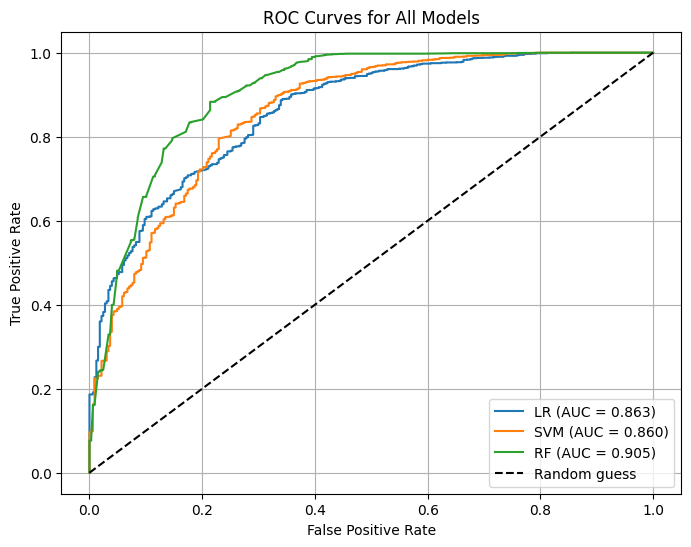

In [ ]:
# ROC CURVES FOR ALL MODELS


from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for model_name, model in best_models.items():
    # get probability or decision scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue  # skip models without scores (rare)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrices for Each Model


Confusion Matrix: LR


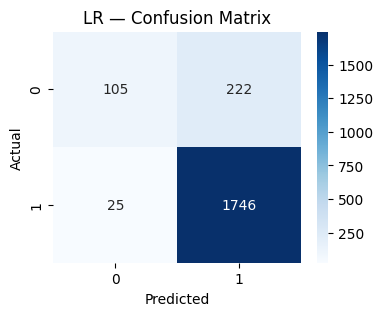


Confusion Matrix: SVM


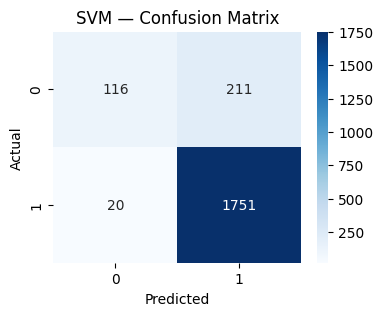


Confusion Matrix: RF


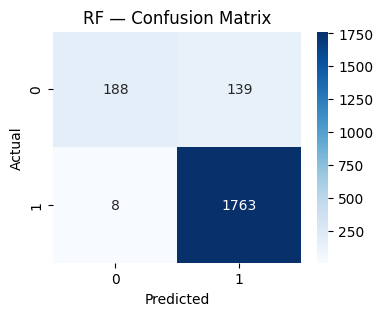

In [ ]:
#  CONFUSION MATRICES

from sklearn.metrics import confusion_matrix

for model_name, model in best_models.items():
    print(f"\nConfusion Matrix: {model_name}")

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
#  TOP TF-IDF FEATURES (Logistic Regression Coeffs)

# FIX: use the correct key
log_reg = best_models["LR"]

feature_names = vectorize_tf.get_feature_names_out()
coef = log_reg.coef_[0]

# Top 20 positive = words predicting HIGH-quality games
top_pos_idx = np.argsort(coef)[-20:]
top_pos_words = [(feature_names[i], coef[i]) for i in top_pos_idx]

# Top 20 negative = words predicting LOW-quality games
top_neg_idx = np.argsort(coef)[:20]
top_neg_words = [(feature_names[i], coef[i]) for i in top_neg_idx]

print("\n Top 20 words predicting HIGH-quality (class = 1):")
for w, c in reversed(top_pos_words):
    print(f"{w:20s} {c:.4f}")

print("\n Top 20 words predicting LOW-quality (class = 0):")
for w, c in top_neg_words:
    print(f"{w:20s} {c:.4f}")


 Top 20 words predicting HIGH-quality (class = 1):
soul                 5.9380
persona              5.4219
dlc                  4.3484
spider               4.2481
atlus                4.2032
masterpiece          4.0709
fantasy              4.0193
rogue                3.9177
platformer           3.7900
alan                 3.6641
silent               3.6325
knight               3.2688
map                  3.2522
wake                 3.0564
soundtrack           2.9679
mission              2.8242
capcom               2.7741
evil                 2.7104
rebirth              2.7033
insane               2.6659

 Top 20 words predicting LOW-quality (class = 0):
yakuza               -13.0536
cat                  -11.9523
engine               -5.8864
short                -4.1379
choice               -3.9981
series               -3.6362
match                -3.2733
decision             -3.2324
movie                -3.2197
awful                -3.0407
bug                  -2.8503
improvement     

## Embedding Model Training (Word2Vec, FastText, GloVe_Giga50)

In [ ]:
#  BEST MODEL PER EMBEDDING TYPE
#  Word2Vec / FastText / GloVe

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, roc_curve, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# PREP FUNCTION — BALANCED BINARY TARGET USING MEDIAN

def prepare_embedding_df(df):
    df = df.dropna(subset=["normalized_meta_score"]).copy()

    # Data-driven threshold for balanced binary classes
    median_score = df["normalized_meta_score"].median()
    print(f"\nMedian normalized_meta_score = {median_score:.4f}")

    df["target_high_meta"] = (df["normalized_meta_score"] >= median_score).astype(int)

    print("Label distribution:")
    print(df["target_high_meta"].value_counts())

    # Identify embedding feature columns
    drop_cols = ["normalized_meta_score",
                 "normalized_user_score",
                 "target_high_meta"]
    feature_cols = [c for c in df.columns if c not in drop_cols]

    df[feature_cols] = df[feature_cols].fillna(0.0)

    return df, feature_cols


In [ ]:
# Re-prepare all embedding DataFrames
w2v_df, w2v_features = prepare_embedding_df(w2v_df)
ft_df, ft_features = prepare_embedding_df(ft_df)
glove_df, glove_features = prepare_embedding_df(glove_df)


Median normalized_meta_score = 0.8400
Label distribution:
target_high_meta
1    5796
0    4694
Name: count, dtype: int64

Median normalized_meta_score = 0.8400
Label distribution:
target_high_meta
1    5796
0    4694
Name: count, dtype: int64

Median normalized_meta_score = 0.8400
Label distribution:
target_high_meta
1    5796
0    4694
Name: count, dtype: int64


In [ ]:
def train_full_models(name, df, feature_cols, random_state=42):
    print("\n====================================")
    print(f" Training on: {name}")
    print("====================================")

    # -------------------------
    # Prepare Data
    # -------------------------
    X = df[feature_cols].values
    y = df["target_high_meta"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    results = []
    best_estimators = {}

    # ======================================================
    # 1. Logistic Regression
    # ======================================================
    print("\nFitting Logistic Regression...")
    pipe_lr = Pipeline([
        ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
    ])

    param_lr = {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"]
    }

    grid_lr = GridSearchCV(pipe_lr, param_lr, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_lr.fit(X_train, y_train)

    best_lr = grid_lr.best_estimator_
    y_pred_lr = best_lr.predict(X_test)
    y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model: Embeddings + Logistic Regression")
    print("Best params:", grid_lr.best_params_)
    print(classification_report(y_test, y_pred_lr))

    results.append(pd.Series({
        "Accuracy": accuracy_score(y_test, y_pred_lr),
        "F1": f1_score(y_test, y_pred_lr),
        "AUC": roc_auc_score(y_test, y_proba_lr)
    }, name="Embeddings + Logistic Regression"))

    best_estimators["LR"] = best_lr

    # ======================================================
    # 2. SVM (RBF)
    # ======================================================
    print("\nFitting SVM (RBF)...")
    pipe_svm = Pipeline([
        ("clf", SVC(probability=True))
    ])

    param_svm = {
        "clf__C": [1, 10],
        "clf__gamma": [0.01, 0.1],
        "clf__kernel": ["rbf"]
    }

    grid_svm = GridSearchCV(pipe_svm, param_svm, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_svm.fit(X_train, y_train)

    best_svm = grid_svm.best_estimator_
    y_pred_svm = best_svm.predict(X_test)
    y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model: Embeddings + SVM (RBF)")
    print("Best params:", grid_svm.best_params_)
    print(classification_report(y_test, y_pred_svm))

    results.append(pd.Series({
        "Accuracy": accuracy_score(y_test, y_pred_svm),
        "F1": f1_score(y_test, y_pred_svm),
        "AUC": roc_auc_score(y_test, y_proba_svm)
    }, name="Embeddings + SVM (RBF)"))

    best_estimators["SVM"] = best_svm

    # ======================================================
    # 3. Random Forest
    # ======================================================
    print("\nFitting Random Forest...")
    pipe_rf = Pipeline([
        ("clf", RandomForestClassifier(random_state=random_state))
    ])

    param_rf = {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    }

    grid_rf = GridSearchCV(pipe_rf, param_rf, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_rf.fit(X_train, y_train)

    best_rf = grid_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model: Embeddings + Random Forest")
    print("Best params:", grid_rf.best_params_)
    print(classification_report(y_test, y_pred_rf))

    results.append(pd.Series({
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "F1": f1_score(y_test, y_pred_rf),
        "AUC": roc_auc_score(y_test, y_proba_rf)
    }, name="Embeddings + Random Forest"))

    best_estimators["RF"] = best_rf

    # ======================================================
    # Comparison Table
    # ======================================================
    results_df = pd.DataFrame(results)
    print(f"\n=== Model Comparison ({name}) ===")
    display(results_df)

    best_model_name = results_df["F1"].idxmax()
    print("\nBest model by F1:", best_model_name)
    print(results_df.loc[best_model_name])

    return results_df, best_estimators

In [ ]:
results_w2v,   best_w2v   = train_full_models("Word2Vec Embeddings",  w2v_df,   w2v_features)
results_ft,    best_ft    = train_full_models("FastText Embeddings", ft_df,    ft_features)
results_glove, best_glove = train_full_models("GloVe Embeddings",    glove_df, glove_features)


 Training on: Word2Vec Embeddings

Fitting Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Model: Embeddings + Logistic Regression
Best params: {'clf__C': 1, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       939
           1       0.75      0.80      0.77      1159

    accuracy                           0.74      2098
   macro avg       0.74      0.73      0.73      2098
weighted avg       0.74      0.74      0.74      2098


Fitting SVM (RBF)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Model: Embeddings + SVM (RBF)
Best params: {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       939
           1       0.76      0.80      0.78      1159

    accuracy                           0.75      

,Accuracy,F1,AUC
Embeddings + Logistic Regression,0.738799,0.772047,0.790531
Embeddings + SVM (RBF),0.752622,0.782024,0.805954
Embeddings + Random Forest,0.763108,0.810233,0.851641



Best model by F1: Embeddings + Random Forest
Accuracy    0.763108
F1          0.810233
AUC         0.851641
Name: Embeddings + Random Forest, dtype: float64

 Training on: FastText Embeddings

Fitting Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Model: Embeddings + Logistic Regression
Best params: {'clf__C': 10, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       939
           1       0.73      0.82      0.77      1159

    accuracy                           0.73      2098
   macro avg       0.73      0.72      0.72      2098
weighted avg       0.73      0.73      0.73      2098


Fitting SVM (RBF)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Model: Embeddings + SVM (RBF)
Best params: {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support


,Accuracy,F1,AUC
Embeddings + Logistic Regression,0.730219,0.769919,0.784906
Embeddings + SVM (RBF),0.706864,0.762640,0.774069
Embeddings + Random Forest,0.772641,0.816468,0.863735



Best model by F1: Embeddings + Random Forest
Accuracy    0.772641
F1          0.816468
AUC         0.863735
Name: Embeddings + Random Forest, dtype: float64

 Training on: GloVe Embeddings

Fitting Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Model: Embeddings + Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.64      0.45      0.53       939
           1       0.64      0.79      0.71      1159

    accuracy                           0.64      2098
   macro avg       0.64      0.62      0.62      2098
weighted avg       0.64      0.64      0.63      2098


Fitting SVM (RBF)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Model: Embeddings + SVM (RBF)
Best params: {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

 

,Accuracy,F1,AUC
Embeddings + Logistic Regression,0.642517,0.710648,0.684737
Embeddings + SVM (RBF),0.678742,0.731474,0.735014
Embeddings + Random Forest,0.747855,0.793117,0.830477



Best model by F1: Embeddings + Random Forest
Accuracy    0.747855
F1          0.793117
AUC         0.830477
Name: Embeddings + Random Forest, dtype: float64


## Create Target + Small Feature Subset (Knowledge-Driven)

In [ ]:
# Ensure required columns exist
required_cols = ["normalized_meta_score", "review_expanded",
                 "polarity", "subjectivity", "compound"]
for col in required_cols:
    if col not in df_sa.columns:
        raise ValueError(f"Missing column in df_sa: {col}")

In [ ]:
# Binary target via median threshold (balanced)
median_meta = df_sa["normalized_meta_score"].median()
print("Median normalized_meta_score:", median_meta)

Median normalized_meta_score: 0.8400000000000001


In [ ]:
df_sa["target_high_meta"] = (df_sa["normalized_meta_score"] >= median_meta).astype(int)

In [ ]:
print("\nLabel counts:")
print(df_sa["target_high_meta"].value_counts(normalize=True))


Label counts:
target_high_meta
1    0.552526
0    0.447474
Name: proportion, dtype: float64


In [ ]:
# Add simple lexical knowledge feature
df_sa["review_length"] = df_sa["review_expanded"].astype(str).apply(lambda x: len(x.split()))

In [ ]:
# Knowledge-driven features
kd_features = ["polarity", "subjectivity", "compound", "review_length"]

In [ ]:
# Filter rows with complete feature information
cols_needed = kd_features + ["target_high_meta"]
df_kd = df_sa.dropna(subset=cols_needed).copy()

print("\nKnowledge-driven subset shape:", df_kd.shape)


Knowledge-driven subset shape: (10490, 8)


In [ ]:
def train_tabular_model(name, X, y, random_state=42):
    print("\n====================================")
    print(f"Training on: {name}")
    print("====================================")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    results = []

    # ------------------------------
    # Logistic Regression
    # ------------------------------
    pipe_lr = Pipeline([
        ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
    ])
    param_lr = {"clf__C": [0.1, 1, 10], "clf__penalty": ["l2"]}

    grid_lr = GridSearchCV(pipe_lr, param_lr, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_lr.fit(X_train, y_train)

    y_pred_lr = grid_lr.best_estimator_.predict(X_test)
    y_proba_lr = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model:", name, "+ Logistic Regression")
    print("Best params:", grid_lr.best_params_)
    print(classification_report(y_test, y_pred_lr))

    results.append(pd.Series({
        "Accuracy": accuracy_score(y_test, y_pred_lr),
        "F1": f1_score(y_test, y_pred_lr),
        "AUC": roc_auc_score(y_test, y_proba_lr)
    }, name=f"{name} + Logistic Regression"))

    # ------------------------------
    # SVM (RBF)
    # ------------------------------
    pipe_svm = Pipeline([("clf", SVC(probability=True))])
    param_svm = {"clf__C": [1, 10], "clf__gamma": [0.1, 0.01]}

    grid_svm = GridSearchCV(pipe_svm, param_svm, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_svm.fit(X_train, y_train)

    y_pred_svm = grid_svm.best_estimator_.predict(X_test)
    y_proba_svm = grid_svm.best_estimator_.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model:", name, "+ SVM (RBF)")
    print("Best params:", grid_svm.best_params_)
    print(classification_report(y_test, y_pred_svm))

    results.append(pd.Series({
        "Accuracy": accuracy_score(y_test, y_pred_svm),
        "F1": f1_score(y_test, y_pred_svm),
        "AUC": roc_auc_score(y_test, y_proba_svm)
    }, name=f"{name} + SVM (RBF)"))

    # ------------------------------
    # Random Forest
    # ------------------------------
    pipe_rf = Pipeline([("clf", RandomForestClassifier(random_state=random_state))])
    param_rf = {"clf__n_estimators": [100, 200],
                "clf__max_depth": [None, 10, 20],
                "clf__min_samples_split": [2, 5]}

    grid_rf = GridSearchCV(pipe_rf, param_rf, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_rf.fit(X_train, y_train)

    y_pred_rf = grid_rf.best_estimator_.predict(X_test)
    y_proba_rf = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print("Model:", name, "+ Random Forest")
    print("Best params:", grid_rf.best_params_)
    print(classification_report(y_test, y_pred_rf))

    results.append(pd.Series({
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "F1": f1_score(y_test, y_pred_rf),
        "AUC": roc_auc_score(y_test, y_proba_rf)
    }, name=f"{name} + Random Forest"))

    # ------------------------------
    # Model Comparison Table
    # ------------------------------
    results_df = pd.DataFrame(results)
    print(f"\n=== Model Comparison ({name}) ===")
    display(results_df)

    best_name = results_df["F1"].idxmax()
    print("\nBest model:", best_name)
    print(results_df.loc[best_name])

    return results_df

In [ ]:
X_kd = df_kd[kd_features].values
y_kd = df_kd["target_high_meta"].values

results_kd = train_tabular_model("Knowledge-driven (Sentiment + Length)", X_kd, y_kd)


Training on: Knowledge-driven (Sentiment + Length)
Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Model: Knowledge-driven (Sentiment + Length) + Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.50      0.06      0.11       939
           1       0.56      0.95      0.70      1159

    accuracy                           0.55      2098
   macro avg       0.53      0.51      0.41      2098
weighted avg       0.53      0.55      0.44      2098

Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Model: Knowledge-driven (Sentiment + Length) + SVM (RBF)
Best params: {'clf__C': 1, 'clf__gamma': 0.01}
              precision    recall  f1-score   support

           0       0.49      0.07      0.12       939
           1       0.56      0.94      0.70      1159

    accuracy                           0.55      209

,Accuracy,F1,AUC
Knowledge-driven (Sentiment + Length) + Logistic Regression,0.552431,0.700669,0.553743
Knowledge-driven (Sentiment + Length) + SVM (RBF),0.551478,0.698494,0.532611
Knowledge-driven (Sentiment + Length) + Random Forest,0.617731,0.699850,0.648644



Best model: Knowledge-driven (Sentiment + Length) + Logistic Regression
Accuracy    0.552431
F1          0.700669
AUC         0.553743
Name: Knowledge-driven (Sentiment + Length) + Logistic Regression, dtype: float64


# FULL TRAINING FUNCTION (KD + Hybrid)

In [ ]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def train_tabular_model_full(name, X, y, feature_names=None, random_state=42):

    print("\n====================================")
    print(f" TRAINING: {name}")
    print("====================================")

    # -------------------
    # Train/test split
    # -------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    results = []
    models = {}

    # ======================================================
    # 1. Logistic Regression
    # ======================================================
    pipe_lr = Pipeline([
        ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
    ])

    params_lr = {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"]
    }

    grid_lr = GridSearchCV(pipe_lr, params_lr, cv=3, scoring="f1", n_jobs=-1, verbose=0)
    grid_lr.fit(X_train, y_train)

    lr_best = grid_lr.best_estimator_
    y_pred_lr = lr_best.predict(X_test)
    y_proba_lr = lr_best.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print(" Logistic Regression")
    print(" Best params:", grid_lr.best_params_)
    print(classification_report(y_test, y_pred_lr))

    acc_lr = accuracy_score(y_test, y_pred_lr)
    f1_lr = f1_score(y_test, y_pred_lr)
    auc_lr = roc_auc_score(y_test, y_proba_lr)

    results.append(["LogisticRegression", acc_lr, f1_lr, auc_lr])
    models["LogisticRegression"] = lr_best

    # Logistic Regression Coefficients (if features provided)
    if feature_names is not None:
        coef = lr_best.named_steps["clf"].coef_[0]
        print("\nTop Logistic Regression positive coefficients (predict HIGH):")
        for i in np.argsort(coef)[-10:]:
            print(f"{feature_names[i]:20s}  {coef[i]:.4f}")

    # ======================================================
    # 2. SVM (RBF)
    # ======================================================
    pipe_svm = Pipeline([
        ("clf", SVC(probability=True))
    ])

    params_svm = {
        "clf__C": [1, 10],
        "clf__gamma": [0.01, 0.1],
        "clf__kernel": ["rbf"]
    }

    grid_svm = GridSearchCV(pipe_svm, params_svm, cv=3, scoring="f1", n_jobs=-1, verbose=0)
    grid_svm.fit(X_train, y_train)

    svm_best = grid_svm.best_estimator_
    y_pred_svm = svm_best.predict(X_test)
    y_proba_svm = svm_best.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print(" SVM (RBF)")
    print(" Best params:", grid_svm.best_params_)
    print(classification_report(y_test, y_pred_svm))

    acc_svm = accuracy_score(y_test, y_pred_svm)
    f1_svm = f1_score(y_test, y_pred_svm)
    auc_svm = roc_auc_score(y_test, y_proba_svm)

    results.append(["SVM (RBF)", acc_svm, f1_svm, auc_svm])
    models["SVM"] = svm_best

    # ======================================================
    # 3. Random Forest
    # ======================================================
    pipe_rf = Pipeline([
        ("clf", RandomForestClassifier(random_state=random_state))
    ])

    params_rf = {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    }

    grid_rf = GridSearchCV(pipe_rf, params_rf, cv=3, scoring="f1", n_jobs=-1, verbose=0)
    grid_rf.fit(X_train, y_train)

    rf_best = grid_rf.best_estimator_
    y_pred_rf = rf_best.predict(X_test)
    y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print(" Random Forest")
    print(" Best params:", grid_rf.best_params_)
    print(classification_report(y_test, y_pred_rf))

    acc_rf = accuracy_score(y_test, y_pred_rf)
    f1_rf = f1_score(y_test, y_pred_rf)
    auc_rf = roc_auc_score(y_test, y_proba_rf)

    results.append(["RandomForest", acc_rf, f1_rf, auc_rf])
    models["RandomForest"] = rf_best

    # RF Feature Importances
    if feature_names is not None:
        print("\nTop Random Forest Feature Importances:")
        importances = rf_best.named_steps["clf"].feature_importances_
        idx = np.argsort(importances)[-10:]
        for i in idx:
            print(f"{feature_names[i]:20s}  {importances[i]:.4f}")

    # ======================================================
    # RESULTS TABLE
    # ======================================================
    results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1", "AUC"])
    print("\n=== Model Comparison ===")
    display(results_df)

    # ======================================================
    # ROC CURVES (all models)
    # ======================================================
    plt.figure(figsize=(8,6))
    for model_name, estimator in models.items():
        y_prob = estimator.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=model_name)
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves — {name}")
    plt.legend()
    plt.show()

    # ======================================================
    # CONFUSION MATRICES
    # ======================================================
    for model_name, estimator in models.items():
        y_pred = estimator.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize= (4,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{model_name} — Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    return results_df, models

## TRAIN KNOWLEDGE-DRIVEN MODELS


 TRAINING: Knowledge-Driven (Sentiment + Length)

------------------------------
 Logistic Regression
 Best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.50      0.06      0.11       939
           1       0.56      0.95      0.70      1159

    accuracy                           0.55      2098
   macro avg       0.53      0.51      0.41      2098
weighted avg       0.53      0.55      0.44      2098


Top Logistic Regression positive coefficients (predict HIGH):
review_length         -0.0000
compound              0.0615
subjectivity          0.1724
polarity              0.4269

------------------------------
 SVM (RBF)
 Best params: {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.49      0.07      0.12       939
           1       0.56      0.94      0.70      1159

    accuracy                           0.55      2098
   macr

,Model,Accuracy,F1,AUC
0,LogisticRegression,0.552431,0.700669,0.553743
1,SVM (RBF),0.551478,0.698494,0.532610
2,RandomForest,0.617731,0.699850,0.648644


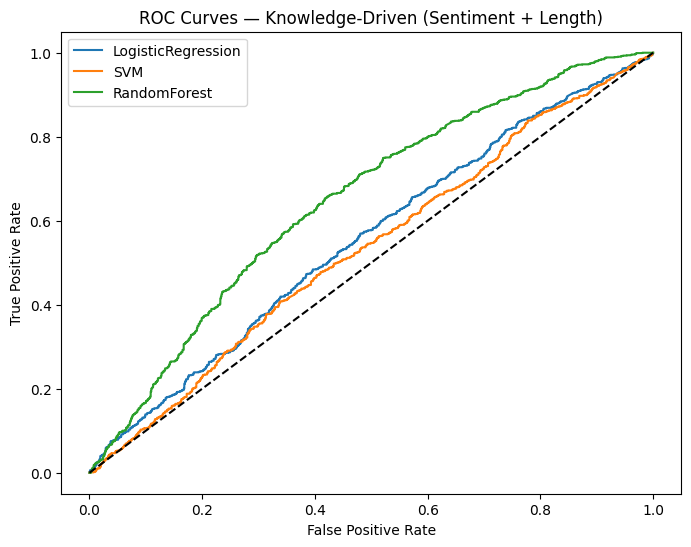

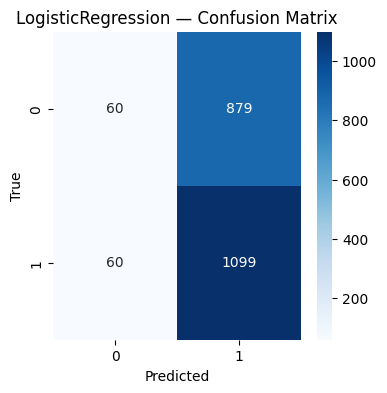

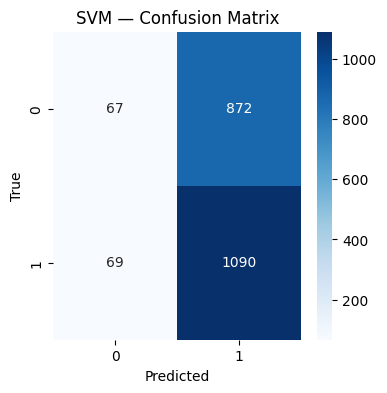

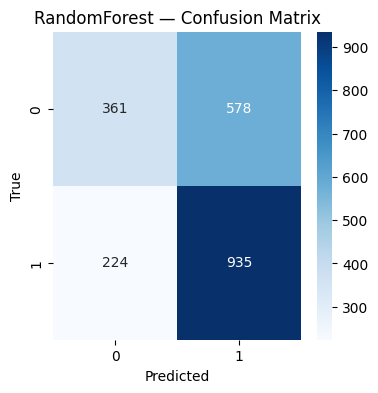

In [ ]:
X_kd = df_kd[kd_features].values
y_kd = df_kd["target_high_meta"].values

results_kd, models_kd = train_tabular_model_full(
    "Knowledge-Driven (Sentiment + Length)",
    X_kd, y_kd,
    feature_names=kd_features
)

## Train Hybrid Models

In [ ]:
# Build Hybrid Feature Set

text_for_tfidf = df_kd["review_expanded"].astype(str).values

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=1000,
    max_df=0.75,
    min_df=5
)

X_tfidf = tfidf.fit_transform(text_for_tfidf)
df_tfidf = pd.DataFrame(X_tfidf.toarray(), index=df_kd.index)

# Combine with KD features
df_hybrid = pd.concat([df_tfidf, df_kd[kd_features]], axis=1)
print("\nHybrid feature shape:", df_hybrid.shape)

X_hybrid = df_hybrid.values
y_hybrid = df_kd["target_high_meta"].values
hybrid_features = list(df_hybrid.columns)



Hybrid feature shape: (10490, 1004)


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def train_tabular_model_full(name, X, y, feature_names, random_state=42):
    print("\n===================================================")
    print(f" TRAINING: {name}")
    print("===================================================\n")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    results = []
    best_models = {}

    # ======================================================
    # 1. Logistic Regression
    # ======================================================
    pipe_lr = Pipeline([
        ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
    ])

    params_lr = {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"]
    }

    grid_lr = GridSearchCV(pipe_lr, params_lr, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_lr.fit(X_train, y_train)

    best_lr = grid_lr.best_estimator_
    y_pred_lr = best_lr.predict(X_test)
    y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print(f"{name} + Logistic Regression")
    print("Best params:", grid_lr.best_params_)
    print(classification_report(y_test, y_pred_lr))

    # Store Metrics
    lr_metrics = {
        "Model": "Logistic Regression",
        "Accuracy": accuracy_score(y_test, y_pred_lr),
        "F1": f1_score(y_test, y_pred_lr),
        "AUC": roc_auc_score(y_test, y_proba_lr),
        "estimator": best_lr
    }
    results.append(lr_metrics)
    best_models["LR"] = best_lr

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_lr)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("LogReg Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
    plt.plot(fpr, tpr, label="LogReg")
    plt.plot([0,1], [0,1], "k--")
    plt.title("LogReg ROC Curve")
    plt.legend()
    plt.show()

    # Feature Importances (coef)
    lr_coef = best_lr.named_steps["clf"].coef_[0]
    top_idx = np.argsort(lr_coef)[-15:]
    print("\nTop LR Features:")
    for i in reversed(top_idx):
        print(f"{feature_names[i]:30s} {lr_coef[i]:.4f}")


    # ======================================================
    # 2. SVM
    # ======================================================
    pipe_svm = Pipeline([
        ("clf", SVC(probability=True))
    ])

    params_svm = {
        "clf__C": [1, 10],
        "clf__gamma": [0.01, 0.1],
        "clf__kernel": ["rbf"]
    }

    grid_svm = GridSearchCV(pipe_svm, params_svm, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_svm.fit(X_train, y_train)

    best_svm = grid_svm.best_estimator_
    y_pred_svm = best_svm.predict(X_test)
    y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print(f"{name} + SVM (RBF)")
    print("Best params:", grid_svm.best_params_)
    print(classification_report(y_test, y_pred_svm))

    svm_metrics = {
        "Model": "SVM",
        "Accuracy": accuracy_score(y_test, y_pred_svm),
        "F1": f1_score(y_test, y_pred_svm),
        "AUC": roc_auc_score(y_test, y_proba_svm),
        "estimator": best_svm
    }
    results.append(svm_metrics)
    best_models["SVM"] = best_svm

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_svm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("SVM Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
    plt.plot(fpr, tpr, label="SVM")
    plt.plot([0,1], [0,1], "k--")
    plt.title("SVM ROC Curve")
    plt.legend()
    plt.show()


    # ======================================================
    # 3. Random Forest
    # ======================================================
    pipe_rf = Pipeline([
        ("clf", RandomForestClassifier(random_state=random_state))
    ])

    params_rf = {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    }

    grid_rf = GridSearchCV(pipe_rf, params_rf, cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid_rf.fit(X_train, y_train)

    best_rf = grid_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

    print("\n------------------------------")
    print(f"{name} + Random Forest")
    print("Best params:", grid_rf.best_params_)
    print(classification_report(y_test, y_pred_rf))

    rf_metrics = {
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "F1": f1_score(y_test, y_pred_rf),
        "AUC": roc_auc_score(y_test, y_proba_rf),
        "estimator": best_rf
    }
    results.append(rf_metrics)
    best_models["RF"] = best_rf

    # Feature Importances
    importances = best_rf.named_steps["clf"].feature_importances_
    idx = np.argsort(importances)[-15:]

    print("\nTop RF Features:")
    for i in reversed(idx):
        print(f"{feature_names[i]:30s} {importances[i]:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Random Forest Confusion Matrix")
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
    plt.plot(fpr, tpr, label="RandomForest")
    plt.plot([0,1], [0,1], "k--")
    plt.title("RandomForest ROC Curve")
    plt.legend()
    plt.show()

    # ======================================================
    # Comparison Table
    # ======================================================
    results_df = pd.DataFrame(results)
    print("\n=== MODEL COMPARISON ===")
    display(results_df)

    # Select Best
    best_model = max(results, key=lambda x: x["F1"])
    print("\nBEST MODEL:", best_model["Model"])
    print(best_model)

    return results_df, best_models


 TRAINING: Hybrid (TF-IDF + Sentiment + Length)

Fitting 3 folds for each of 3 candidates, totalling 9 fits

------------------------------
Hybrid (TF-IDF + Sentiment + Length) + Logistic Regression
Best params: {'clf__C': 1, 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       939
           1       0.80      0.86      0.83      1159

    accuracy                           0.80      2098
   macro avg       0.80      0.80      0.80      2098
weighted avg       0.80      0.80      0.80      2098



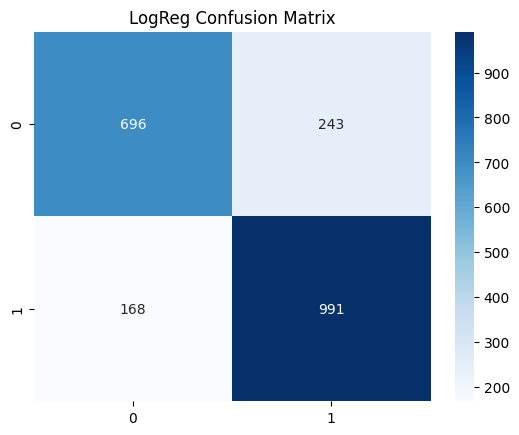

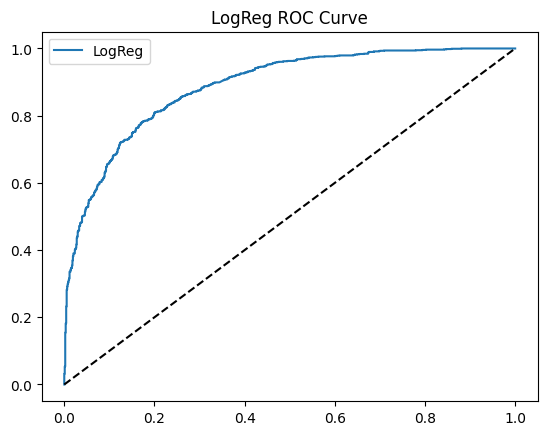


Top LR Features:
825                            5.4006
662                            5.3563
248                            3.6767
62                             3.5644
725                            3.1630
128                            3.0843
507                            2.8822
124                            2.8428
682                            2.6731
259                            2.6508
492                            2.6495
376                            2.5972
4                              2.5702
970                            2.5672
737                            2.5299
Fitting 3 folds for each of 4 candidates, totalling 12 fits

------------------------------
Hybrid (TF-IDF + Sentiment + Length) + SVM (RBF)
Best params: {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       939
           1       0.74      0.79      0.77      1159

    accuracy                          

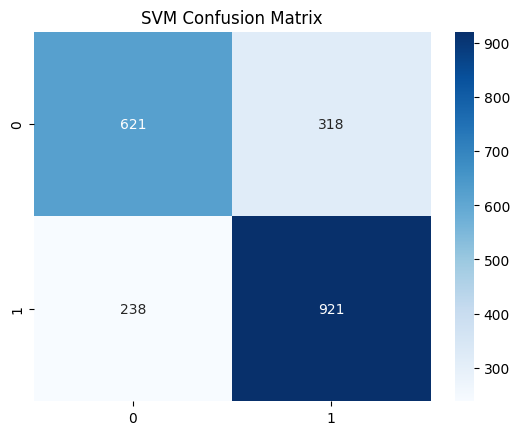

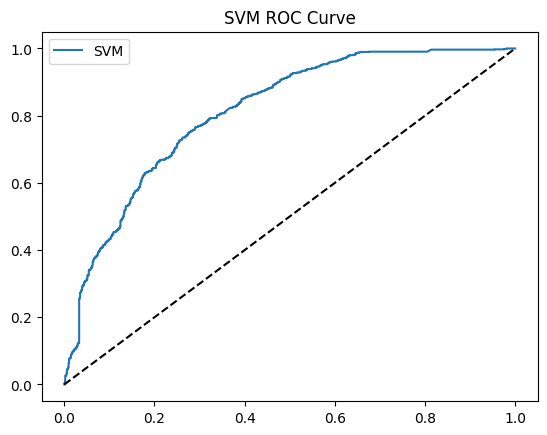

Fitting 3 folds for each of 12 candidates, totalling 36 fits

------------------------------
Hybrid (TF-IDF + Sentiment + Length) + Random Forest
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       939
           1       0.83      0.90      0.86      1159

    accuracy                           0.84      2098
   macro avg       0.84      0.83      0.83      2098
weighted avg       0.84      0.84      0.84      2098


Top RF Features:
polarity                       0.0166
compound                       0.0166
subjectivity                   0.0163
review_length                  0.0160
662                            0.0145
825                            0.0143
718                            0.0122
132                            0.0121
995                            0.0099
92                             0.0095
453                            0.008

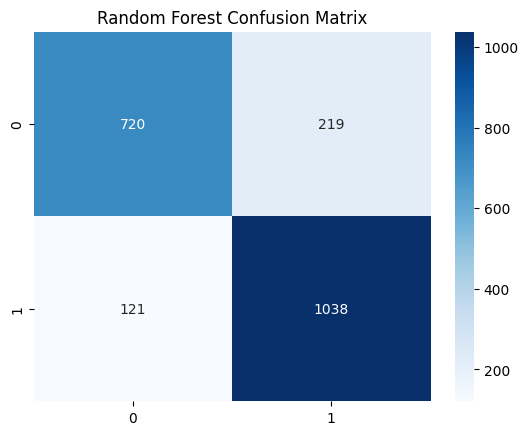

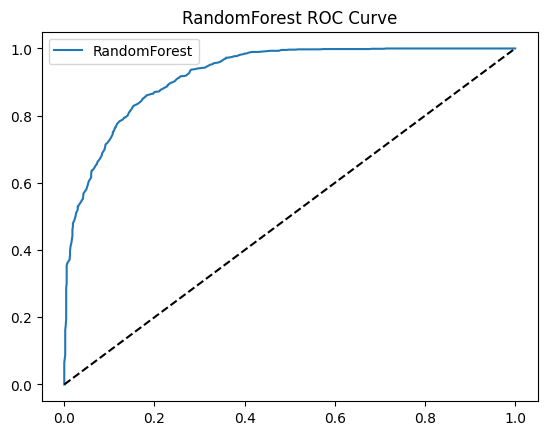


=== MODEL COMPARISON ===


,Model,Accuracy,F1,AUC,estimator
0,Logistic Regression,0.804099,0.828249,0.887719,"(LogisticRegression(C=1, max_iter=2000, solver..."
1,SVM,0.734986,0.768140,0.812325,"(SVC(C=10, gamma=0.1, probability=True))"
2,Random Forest,0.837941,0.859272,0.923250,"((DecisionTreeClassifier(max_features='sqrt', ..."



BEST MODEL: Random Forest
{'Model': 'Random Forest', 'Accuracy': 0.8379408960915157, 'F1': 0.859271523178808, 'AUC': np.float64(0.9232500934943549), 'estimator': Pipeline(steps=[('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))])}


In [ ]:
# Hybrid Model Training
X_hybrid = df_hybrid.values
y_hybrid = df_kd["target_high_meta"].values

# FIX: convert feature names to strings
hybrid_features = [str(f) for f in df_hybrid.columns]

results_hybrid, models_hybrid = train_tabular_model_full(
    "Hybrid (TF-IDF + Sentiment + Length)",
    X_hybrid, y_hybrid,
    feature_names=hybrid_features
)

## Saving Files

In [ ]:
df_en.to_csv("df_en_fuzz_cleaned.csv", index=False)
print("Saved: df_en_fuzz_cleaned.csv")

Saved: df_en_fuzz_cleaned.csv


## Save Lemma-only file (good for reproducibility or later NLP models)

In [ ]:
df_lemmas.to_csv("df_lemmas_fuzz.csv", index=False)
print("Saved: df_lemmas_fuzz.csv")

Saved: df_lemmas_fuzz.csv


## Save Knowledge-Driven dataset (for sentiment-based ML)

In [ ]:
df_kd.to_csv("df_kd_sentiment_fuzz.csv", index=False)
print("Saved: df_kd_sentiment_fuzz.csv")

Saved: df_kd_sentiment_fuzz.csv


## Save TF-IDF matrices if needed

### Frequency BOW

In [ ]:
df_bow_freq.to_csv("bow_frequency_fuzz.csv", index=False)

### Binary BOW

In [ ]:
df_bow_bin = pd.DataFrame(
    vectorize_BOW.transform(df_lemmas['Review_Final']).toarray(),
    columns=vectorize_BOW.get_feature_names_out()
)
df_bow_bin.to_csv("bow_binary_fuzz.csv", index=False)

### TF-IDF

In [ ]:
df_tfidf.to_csv("tfidf_fuzz.csv", index=False)

## Save Embedding Matrices (Word2Vec, FastText, GloVe)

### Word2Vec

In [ ]:
w2v_df.to_csv("embeddings_w2v_google300_fuzz.csv", index=False)

### FastText

In [ ]:
ft_df.to_csv("embeddings_fasttext_300_fuzz.csv", index=False)

### Glove

In [ ]:
glove_df.to_csv("embeddings_glove_fuzz.csv", index=False)

## Save Hybrid TF-IDF + KD Feature Matrix

In [ ]:
df_hybrid.to_csv("hybrid_tfidf_kd_fuzz.csv", index=False)
print("Saved: hybrid_tfidf_kd_fuzz.csv")

Saved: hybrid_tfidf_kd_fuzz.csv


## Save Topic Modeling Inputs

In [ ]:
pd.DataFrame({"texts_lda": texts_lda}).to_csv("lda_texts_fuzz.csv", index=False)
id2word_lda.save_as_text("lda_dictionary_fuzz.txt")

In [ ]:
# Ensure review_fuzzed exists in df_en
if "review_fuzzed" not in df_en.columns:
    df_en["review_fuzzed"] = df_raw.loc[df_en.index, "review_fuzzed"]

In [ ]:
df_en.to_csv("df_en_fuzz_cleaned.csv", index=False)
from google.colab import files
files.download("df_en_fuzz_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_raw.to_csv("raw_with_fuzz_review.csv", index=False)
files.download("raw_with_fuzz_review.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_en.to_csv("df_en_fuzz_cleaned.csv", index=False)
files.download("df_en_fuzz_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>